# Промышленная обработка стали

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/91/Steel_Melting_Process.jpg/303px-Steel_Melting_Process.jpg 'Afdmcc')

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. _tribe_, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. _slab_, «плита»).

## Загрузка и ознакомление с данными

In [ ]:
! gdown 1Xlw9kx00QSHcihVa0OwPN-rHsXhJwWVf

Downloading...
From: https://drive.google.com/uc?id=1Xlw9kx00QSHcihVa0OwPN-rHsXhJwWVf
To: /content/final_steel.zip
100% 610k/610k [00:00<00:00, 108MB/s]


In [ ]:
! unzip -uq /content/final_steel.zip

In [ ]:
! pip install catboost --quiet
! pip install optuna --quiet
! pip install phik --quiet

In [ ]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import VotingRegressor

from catboost import CatBoostRegressor
from catboost import cv
from catboost import Pool

import phik

import optuna
from optuna.samplers import RandomSampler

In [ ]:
sns.set(rc={'figure.figsize': (15, 9)})
sns.set_style('darkgrid')

In [ ]:
RANDOM_STATE = 11122

In [ ]:
sampler = RandomSampler(seed=RANDOM_STATE)

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

Данные состоят из файлов, полученных из разных источников:
- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

In [ ]:
try:
    df_arc = pd.read_csv('/content/final_steel/data_arc.csv', parse_dates=[1, 2])
except:    
    df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv',  parse_dates=[1, 2])

In [ ]:
try:
    df_bulk = pd.read_csv('/content/final_steel/data_bulk.csv')
except:
    df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')

In [ ]:
try:
    df_bulk_time = pd.read_csv('/content/final_steel/data_bulk_time.csv', parse_dates=list(range(1, 16)))
except: 
    df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv', parse_dates=list(range(1, 16)))

In [ ]:
try:
    df_gas = pd.read_csv('/content/final_steel/data_gas.csv')
except:
    df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')

In [ ]:
try:
    df_temp = pd.read_csv('/content/final_steel/data_temp.csv', parse_dates=[1])
except:
    df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv', parse_dates=[1])

In [ ]:
try:
    
    df_wire = pd.read_csv('/content/final_steel/data_wire.csv')
except:
    df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')

In [ ]:
try:
    df_wire_time = pd.read_csv('/content/final_steel/data_wire_time.csv', parse_dates=list(range(1, 10)))
except:
    df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv', parse_dates=list(range(1, 10)))

### Данные об электродах

In [ ]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [ ]:
df_arc.describe(datetime_is_numeric=True)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-02 16:15:28.218203904,2019-07-02 16:18:19.889150208,0.670441,0.452592
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.030002,-715.504924
25%,806.000000,2019-06-02 07:01:09.249999872,2019-06-02 07:04:21,0.395297,0.290991
50%,1617.000000,2019-06-30 09:57:14.500000,2019-06-30 10:01:01,0.555517,0.415962
75%,2429.000000,2019-08-03 13:04:47.750000128,2019-08-03 13:09:14,0.857034,0.637371
max,3241.000000,2019-09-01 04:34:47,2019-09-01 04:36:08,3.731596,2.676388
std,934.571502,NaN,NaN,0.408159,5.878702


In [ ]:
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [ ]:
df_arc.duplicated().sum()

0

В файле с данными 14876 записей. Пропусков данных и дубликатов нет. В двух колонках содержатся данные о времени.

### Данные о подаче сыпучих материалов (объём)

In [ ]:
df_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [ ]:
df_bulk.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


In [ ]:
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [ ]:
df_bulk.isna().sum().to_frame()

,0
key,0
Bulk 1,2877
Bulk 2,3107
Bulk 3,1831
Bulk 4,2115
Bulk 5,3052
Bulk 6,2553
Bulk 7,3104
Bulk 8,3128
Bulk 9,3110


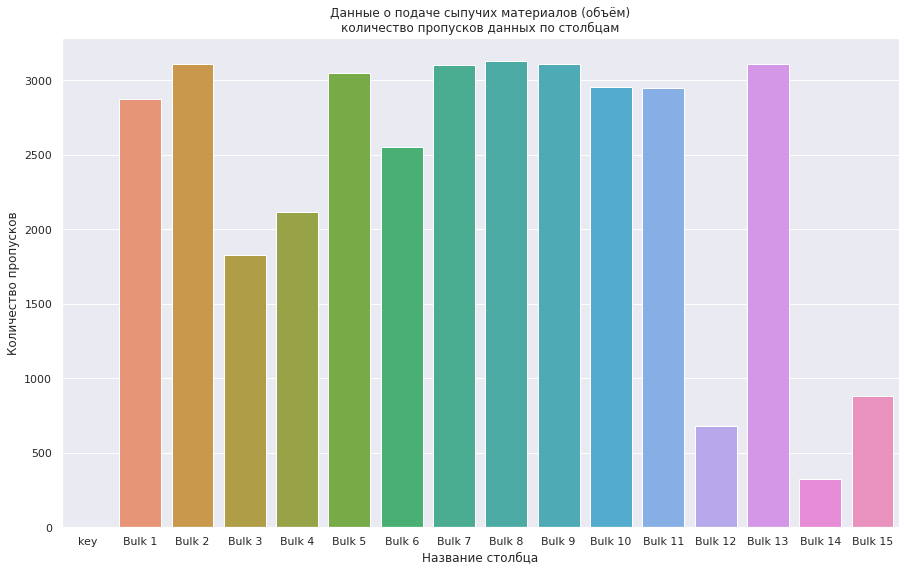

In [ ]:
sns.countplot(data=df_bulk.isna().replace({True: 1, False: np.nan}))\
.set(title='''Данные о подаче сыпучих материалов (объём)
количество пропусков данных по столбцам''',
xlabel='Название столбца',
ylabel='Количество пропусков');

In [ ]:
df_bulk.duplicated().sum()

0

В файле с данными 3129 записей. Пропуски содержатся во всех столбцах кроме `key`. Дубликатов данных нет.

Природа пропусков данных известна от заказчика: если в какой-то момент времени материал не подавался, ставился пропуск.

### Данные о подаче сыпучих материалов (время)

In [ ]:
df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [ ]:
df_bulk_time.describe(datetime_is_numeric=True).T

,count,mean,min,25%,50%,75%,max,std
key,3129.0,1624.383509,1.0,816.0,1622.0,2431.0,3241.0,933.337642
Bulk 1,252,2019-06-27 08:32:26.031746048,2019-05-03 17:50:19,2019-05-28 02:36:05.750000128,2019-06-23 02:31:45.500000,2019-07-27 00:38:33.249999872,2019-08-30 23:01:32,NaN
Bulk 2,22,2019-07-09 02:04:44.545454336,2019-05-07 08:36:19,2019-05-26 21:24:43.249999872,2019-07-23 15:06:49.500000,2019-08-08 10:55:53.750000128,2019-08-08 17:34:38,NaN
Bulk 3,1298,2019-07-05 14:02:19.653312768,2019-05-03 20:13:36,2019-06-06 08:39:05.500000,2019-07-01 17:13:22,2019-08-06 14:11:27.750000128,2019-08-31 23:39:11,NaN
Bulk 4,1014,2019-06-30 17:27:38.687376896,2019-05-03 11:21:30,2019-05-29 08:23:05.750000128,2019-06-25 18:44:37.500000,2019-07-30 21:37:44,2019-08-30 17:36:30,NaN
Bulk 5,77,2019-07-10 12:23:28.623376640,2019-05-07 08:36:19,2019-06-17 19:42:11,2019-07-21 23:25:54,2019-08-08 11:51:23,2019-08-28 09:01:08,NaN
Bulk 6,576,2019-07-03 15:57:30.003472384,2019-05-03 18:52:57,2019-06-05 04:40:07,2019-07-06 03:56:28.500000,2019-08-03 09:02:40.750000128,2019-09-01 03:12:40,NaN
Bulk 7,25,2019-07-23 21:38:41.040000,2019-05-07 11:37:42,2019-07-17 11:25:12,2019-07-23 15:37:44,2019-08-08 12:03:38,2019-08-31 07:22:25,NaN
Bulk 8,1,2019-07-05 17:46:11,2019-07-05 17:46:11,2019-07-05 17:46:11,2019-07-05 17:46:11,2019-07-05 17:46:11,2019-07-05 17:46:11,NaN
Bulk 9,19,2019-06-21 00:53:43.157894912,2019-05-14 00:04:56,2019-05-14 02:37:23.500000,2019-05-14 05:15:06,2019-08-11 11:43:13,2019-08-11 15:09:33,NaN


In [ ]:
df_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56


In [ ]:
df_bulk_time.isna().sum(axis=0).to_frame()

,0
key,0
Bulk 1,2877
Bulk 2,3107
Bulk 3,1831
Bulk 4,2115
Bulk 5,3052
Bulk 6,2553
Bulk 7,3104
Bulk 8,3128
Bulk 9,3110


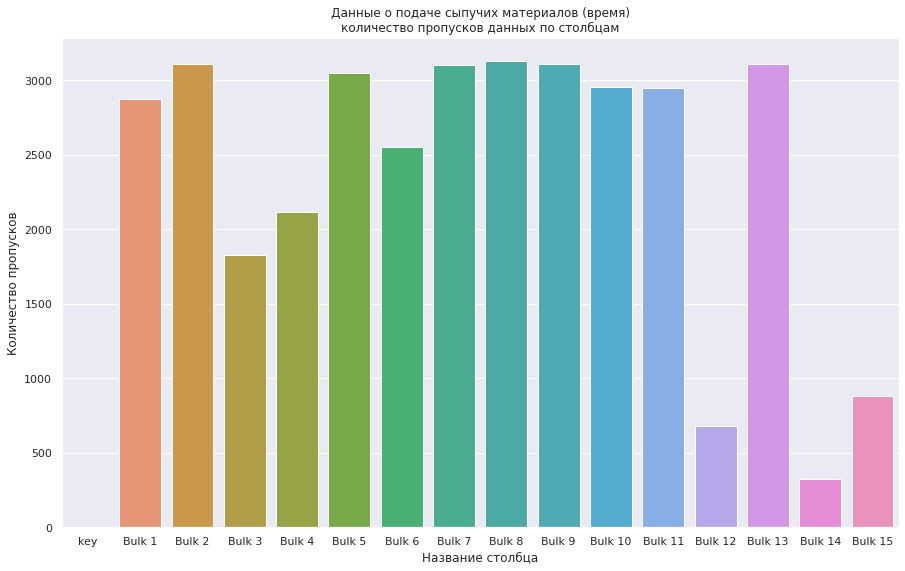

In [ ]:
sns.countplot(data=df_bulk_time.isna().replace({True: 1, False: np.nan}))\
.set(title='''Данные о подаче сыпучих материалов (время)
количество пропусков данных по столбцам''',
xlabel='Название столбца',
ylabel='Количество пропусков');

In [ ]:
# проверка, что пропуски данных совпадают
(df_bulk_time.isna() == df_bulk.isna()).sum().to_frame()

,0
key,3129
Bulk 1,3129
Bulk 2,3129
Bulk 3,3129
Bulk 4,3129
Bulk 5,3129
Bulk 6,3129
Bulk 7,3129
Bulk 8,3129
Bulk 9,3129


В файле с данными 3129 записей. Пропуски содержатся во всех столбцах кроме `key`. Дубликатов данных нет. Пропуски совпадают с пропусками в наборе `df_bulk`.

### Данные о продувке сплава газом

In [ ]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [ ]:
df_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [ ]:
df_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [ ]:
df_gas.duplicated().sum()

0

В наборе данных 3239 записей. Пропусков и дубликатов нет. 

### Результаты измерения температуры

In [ ]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [ ]:
df_temp.describe(datetime_is_numeric=True)

,key,Время замера,Температура
count,15907.000000,15907,13006.000000
mean,1607.880870,2019-07-02 09:55:01.000942848,1591.840920
min,1.000000,2019-05-03 11:16:18,1191.000000
25%,790.000000,2019-06-01 16:24:51.500000,1581.000000
50%,1618.000000,2019-06-30 10:31:14,1591.000000
75%,2427.000000,2019-08-03 12:07:59,1601.000000
max,3241.000000,2019-09-01 04:38:08,1705.000000
std,942.212073,NaN,21.375851


In [ ]:
df_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [ ]:
df_temp.duplicated().sum()

0

In [ ]:
df_temp.isna().sum().to_frame()

,0
key,0
Время замера,0
Температура,2901


В данных по измерениям температуры 15907 записей. В столбце `Температура` содержится 2901 пропуск. Мы имеем дело с промышленными данными, можно предположить, что пропуски возникли при отказах измерительного оборудования. Дубликатов данных нет.

### Данные о проволочных материалах (объём)

In [ ]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [ ]:
df_wire.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Wire 4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


In [ ]:
df_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_wire.isna().sum().to_frame()

,0
key,0
Wire 1,26
Wire 2,2002
Wire 3,3018
Wire 4,3067
Wire 5,3080
Wire 6,3008
Wire 7,3070
Wire 8,3062
Wire 9,3052


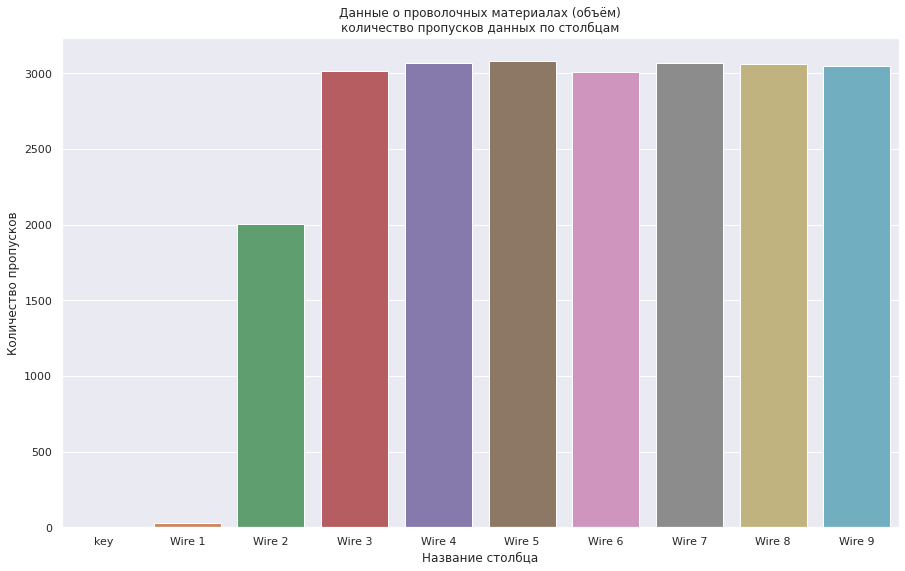

In [ ]:
sns.countplot(data=df_wire.isna().replace({True: 1, False: np.nan}))\
.set(title='''Данные о проволочных материалах (объём)
количество пропусков данных по столбцам''',
xlabel='Название столбца',
ylabel='Количество пропусков');

В файле с данными 3081 запись. Пропуски содержатся во всех столбцах кроме `key`. Дубликатов данных нет.

Природа пропусков известна от заказчика: если в какой-то момент времени материал не подавался, ставился пропуск.

### Данные о проволочных материалах (время)

In [ ]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [ ]:
df_wire_time.describe(datetime_is_numeric=True).T

,count,mean,min,25%,50%,75%,max,std
key,3081.0,1623.426485,1.0,823.0,1619.0,2434.0,3241.0,932.996726
Wire 1,3055,2019-07-03 02:48:18.296235776,2019-05-03 11:11:41,2019-06-03 02:59:53.500000,2019-06-30 14:38:56,2019-08-03 22:58:26,2019-09-01 04:16:01,NaN
Wire 2,1079,2019-07-04 03:36:02.886005504,2019-05-03 13:32:06,2019-06-03 21:52:38,2019-07-02 06:40:13,2019-08-04 13:10:39.500000,2019-08-31 18:50:15,NaN
Wire 3,63,2019-07-07 13:45:31.634920704,2019-05-04 04:47:53,2019-06-09 14:51:42.500000,2019-07-17 21:35:47,2019-08-08 10:03:45,2019-08-28 02:11:18,NaN
Wire 4,14,2019-07-08 10:06:53.999999744,2019-05-07 08:48:23,2019-07-17 08:17:59,2019-07-23 10:44:22.500000,2019-07-23 15:27:14.750000128,2019-08-08 12:03:12,NaN
Wire 5,1,2019-08-08 16:01:07,2019-08-08 16:01:07,2019-08-08 16:01:07,2019-08-08 16:01:07,2019-08-08 16:01:07,2019-08-08 16:01:07,NaN
Wire 6,73,2019-07-04 11:29:18.273972480,2019-05-07 08:37:20,2019-05-08 13:11:38,2019-07-24 03:28:47,2019-08-08 20:28:45,2019-08-14 00:59:11,NaN
Wire 7,11,2019-08-02 18:36:35.818181632,2019-07-23 12:08:44,2019-07-23 19:31:31,2019-08-08 10:43:30,2019-08-08 12:43:10.500000,2019-08-08 18:27:34,NaN
Wire 8,19,2019-06-21 00:52:37.894736896,2019-05-14 00:03:32,2019-05-14 02:36:03.500000,2019-05-14 05:14:25,2019-08-11 11:43:21.500000,2019-08-11 15:09:29,NaN
Wire 9,29,2019-06-28 18:07:46.931034624,2019-05-04 16:09:11,2019-06-07 20:28:19,2019-06-09 10:26:00,2019-08-04 20:48:59,2019-08-29 03:51:31,NaN


In [ ]:
df_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [ ]:
df_wire_time.isna().sum().to_frame()

,0
key,0
Wire 1,26
Wire 2,2002
Wire 3,3018
Wire 4,3067
Wire 5,3080
Wire 6,3008
Wire 7,3070
Wire 8,3062
Wire 9,3052


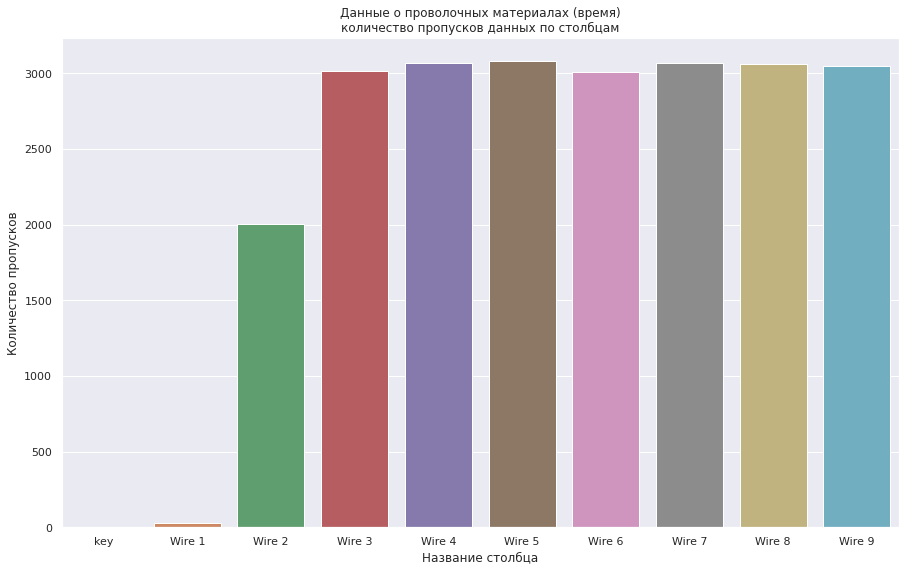

In [ ]:
sns.countplot(data=df_wire_time.isna().replace({True: 1, False: np.nan}))\
.set(title='''Данные о проволочных материалах (время)
количество пропусков данных по столбцам''',
xlabel='Название столбца',
ylabel='Количество пропусков');

In [ ]:
# проверка, что пропуски данных совпадают
(df_wire_time.isna() == df_wire.isna()).sum().to_frame()

,0
key,3081
Wire 1,3081
Wire 2,3081
Wire 3,3081
Wire 4,3081
Wire 5,3081
Wire 6,3081
Wire 7,3081
Wire 8,3081
Wire 9,3081


В файле с данными 3081 запись. Пропуски содержатся во всех столбцах кроме `key`. Дубликатов данных нет. Пропуски совпадают с пропусками в наборе `df_wire`.

### Промежуточные выводы

Мы загрузили семь файлов с данными. Количество строк в файлах различается от 3081 до 14876 штук. Дубликатов данных ни в одном файле обнаружено не было. Во всех файлах были найдены пропуски данных. Каждый файл содержит столбец `key`, возможно его можно будет использовать для объединения таблиц.

## Исследовательский анализ данных

### Данные об электродах

Посмотрим на данные подробнее. Остановимся на каждом столбце в отдельности.

In [ ]:
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [ ]:
df_arc.describe().T

,count,mean,std,min,25%,50%,75%,max
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000
Активная мощность,14876.0,0.670441,0.408159,0.030002,0.395297,0.555517,0.857034,3.731596
Реактивная мощность,14876.0,0.452592,5.878702,-715.504924,0.290991,0.415962,0.637371,2.676388


In [ ]:
df_arc['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

In [ ]:
df_arc['key'].nunique()

3214

In [ ]:
df_arc['key'].value_counts().head().to_frame()

,key
2108,16
1513,15
1689,15
2567,14
46,13


В столбце `key` содержатся 3241 уникальный номер партии. Различные номера повторяются не одинаковое количество раз: больше всего записей (16) относятся к 2108 номеру партии.

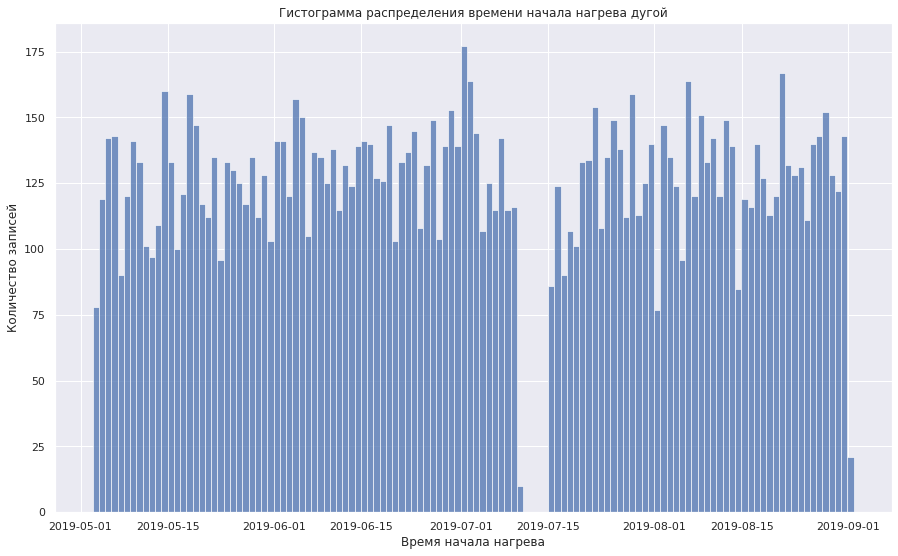

In [ ]:
sns.histplot(data=df_arc, x='Начало нагрева дугой', discrete=True)\
.set(title='Гистограмма распределения времени начала нагрева дугой',
     xlabel='Время начала нагрева',
     ylabel='Количество записей');

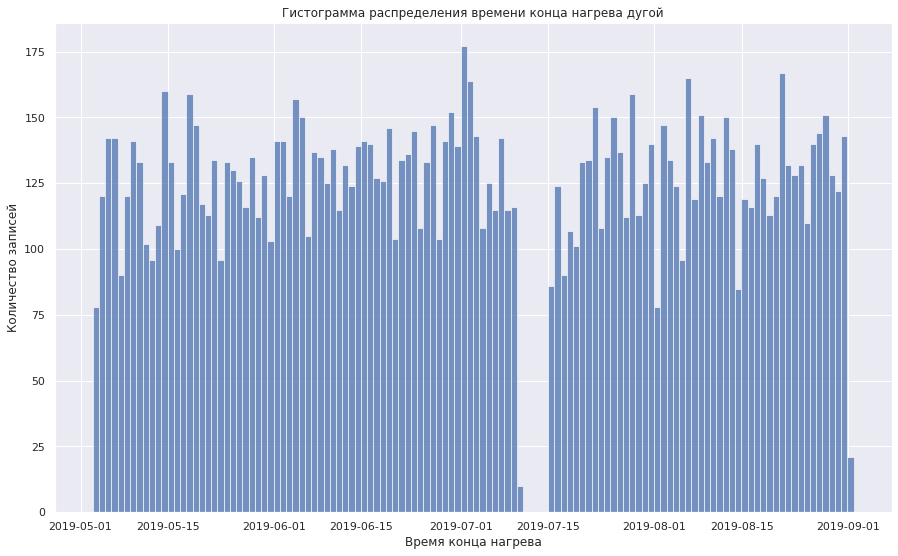

In [ ]:
sns.histplot(data=df_arc, x='Конец нагрева дугой', discrete=True)\
.set(title='Гистограмма распределения времени конца нагрева дугой',
     xlabel='Время конца нагрева',
     ylabel='Количество записей');

In [ ]:
df_arc['Начало нагрева дугой'].dt.day[df_arc['Начало нагрева дугой'].dt.month == 7].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [ ]:
df_arc['Конец нагрева дугой'].dt.day[df_arc['Конец нагрева дугой'].dt.month == 7].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

В колонках `Начало нагрева дугой` и `Конец нагрева дугой` содержатся данные с 3 мая по 1 сентября 2019 года. Данные за 11, 12, 13 июля отсутствуют. Данных за 10 июля подозрительно мало. Возможно в это время на производстве произошёл сбой.

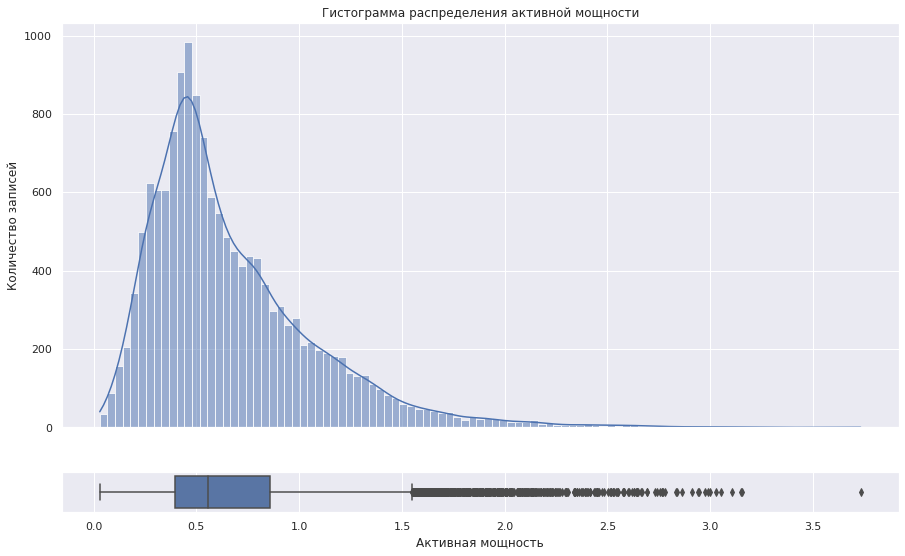

In [ ]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 9), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[10,1]))
hist = sns.histplot(data=df_arc, x='Активная мощность', kde=True, ax=axs_hist)
box = sns.boxplot(data=df_arc, x='Активная мощность', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения активной мощности',
         ylabel='Количество записей')
box.set(xlabel='Активная мощность');

Распределение активной мощности похоже на распределение Пуассона с длинным правым хвостом. Среднее — 0.67, стандартное отклонение — 0.41.

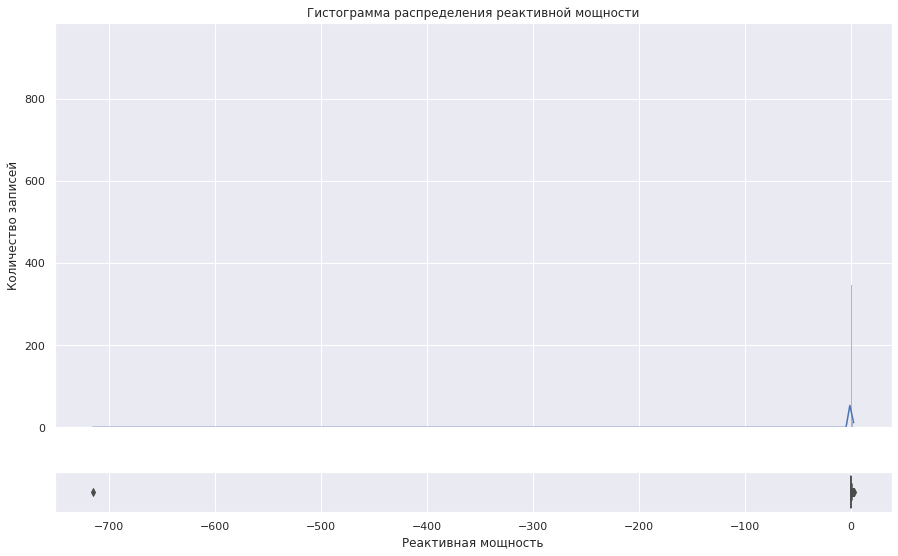

In [ ]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 9), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[10,1]))
hist = sns.histplot(data=df_arc, x='Реактивная мощность', kde=True, ax=axs_hist)
box = sns.boxplot(data=df_arc, x='Реактивная мощность', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения реактивной мощности',
         ylabel='Количество записей')
box.set(xlabel='Реактивная мощность');

Ой. Похоже, что в данных есть выброс. Посмотрим на распределение без него.

In [ ]:
df_arc[df_arc['Реактивная мощность'] > 0].describe().T

,count,mean,std,min,25%,50%,75%,max
key,14875.0,1615.186756,934.593897,1.000000,806.000000,1617.000000,2429.000000,3241.000000
Активная мощность,14875.0,0.670453,0.408170,0.030002,0.395295,0.555565,0.857049,3.731596
Реактивная мощность,14875.0,0.500723,0.310880,0.020806,0.291003,0.415984,0.637403,2.676388


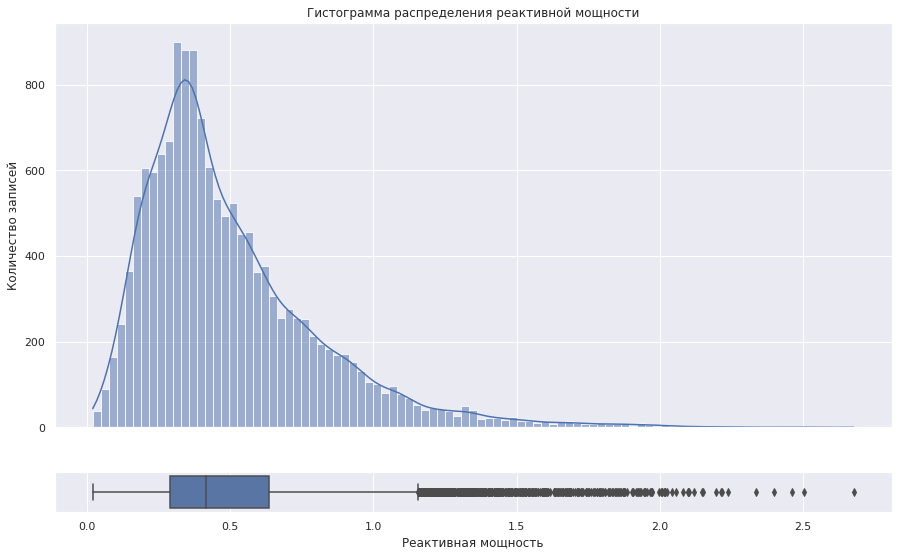

In [ ]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 9), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[10,1]))
hist = sns.histplot(data=df_arc[df_arc['Реактивная мощность'] > 0], 
                    x='Реактивная мощность', kde=True, ax=axs_hist)
box = sns.boxplot(data=df_arc[df_arc['Реактивная мощность'] > 0], 
                  x='Реактивная мощность', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения реактивной мощности',
         ylabel='Количество записей')
box.set(xlabel='Реактивная мощность');

На очищенных данных распределение снова напоминает распределение Пуассона. Среднее — 0.50, стандартное отклонение — 0.31.

Скорее всего перед обучением модели ключ с выбросом придётся удалить.

### Данные о подаче сыпучих материалов (объём)

In [ ]:
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [ ]:
df_bulk.key.unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

In [ ]:
df_bulk.key.nunique()

3129

In [ ]:
df_bulk.key.value_counts().to_frame().head()

,key
1,1
2174,1
2152,1
2153,1
2154,1


В данных содержатся 3129 уникальных ключей с номерами от 1 до 3241. Кажому ключу соответствует только одна запись.

Посмотрим гистограммы для отдельных материалов.

In [ ]:
bulks = df_bulk.columns
bulks = bulks.to_list()[1:]

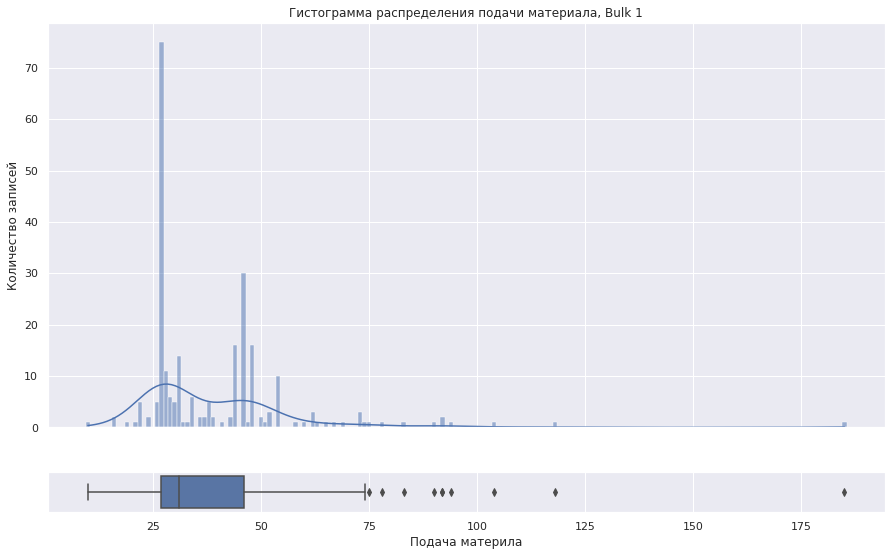

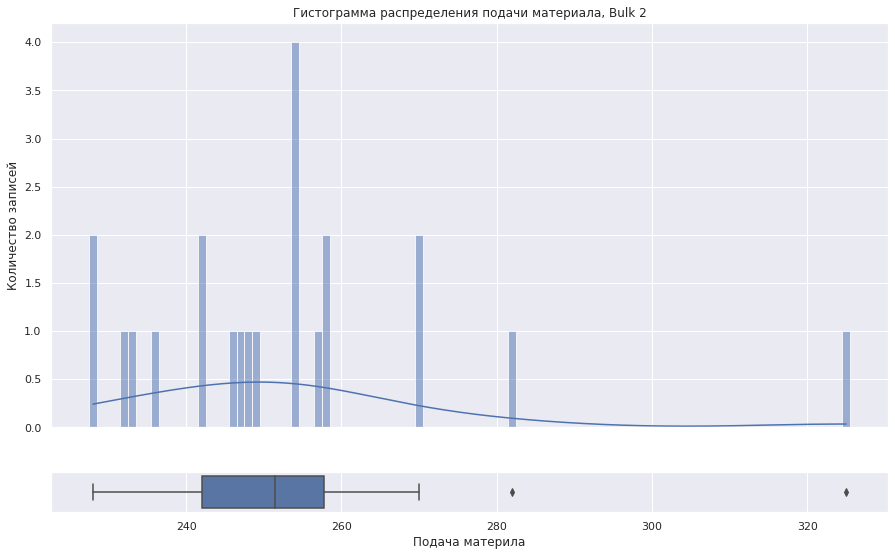

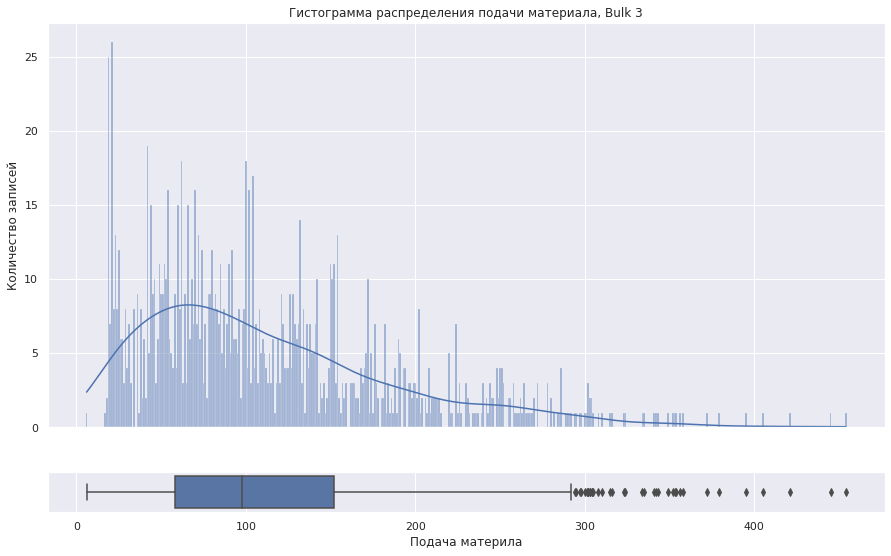

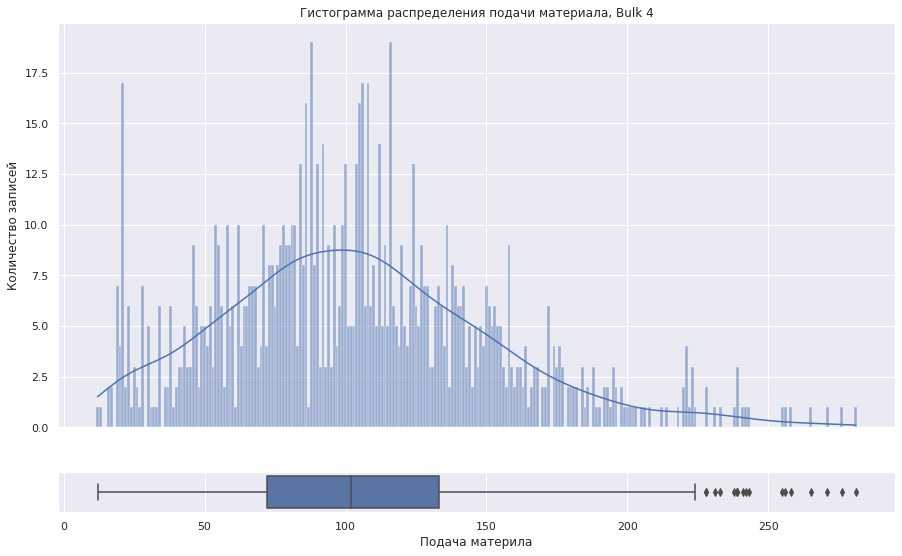

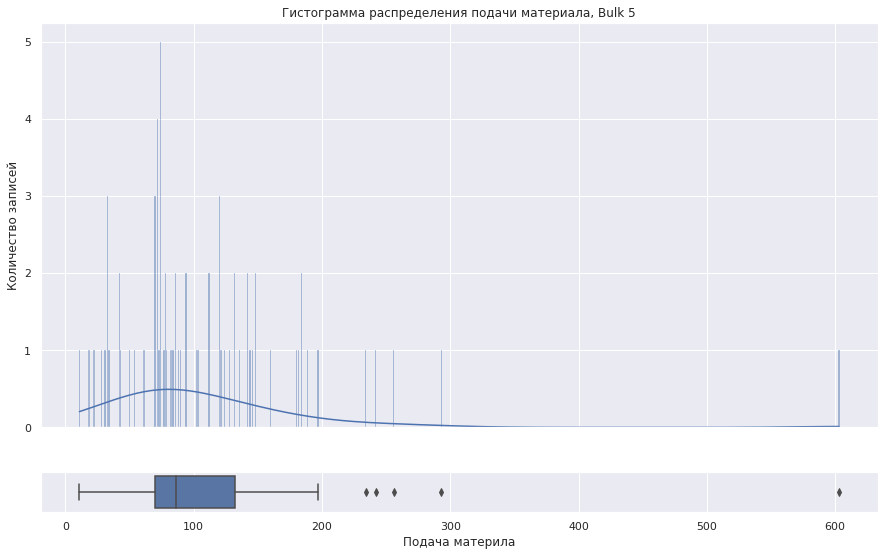

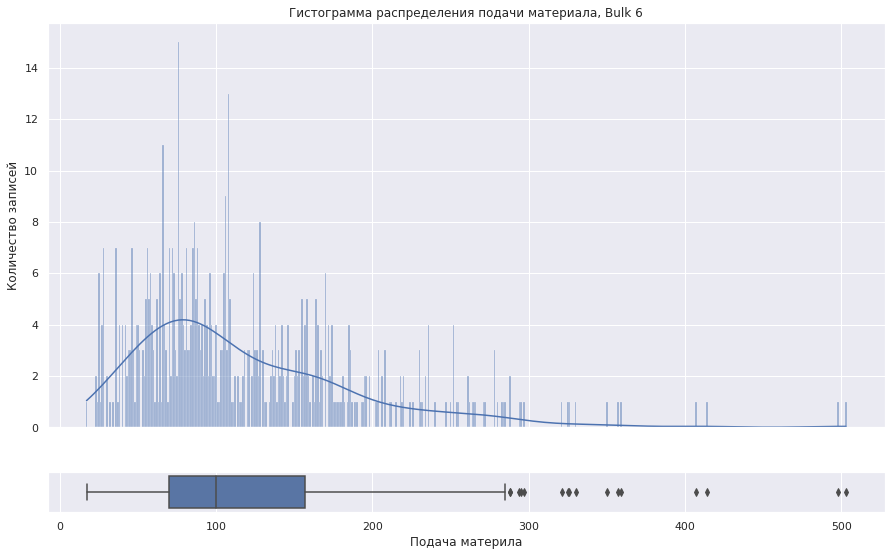

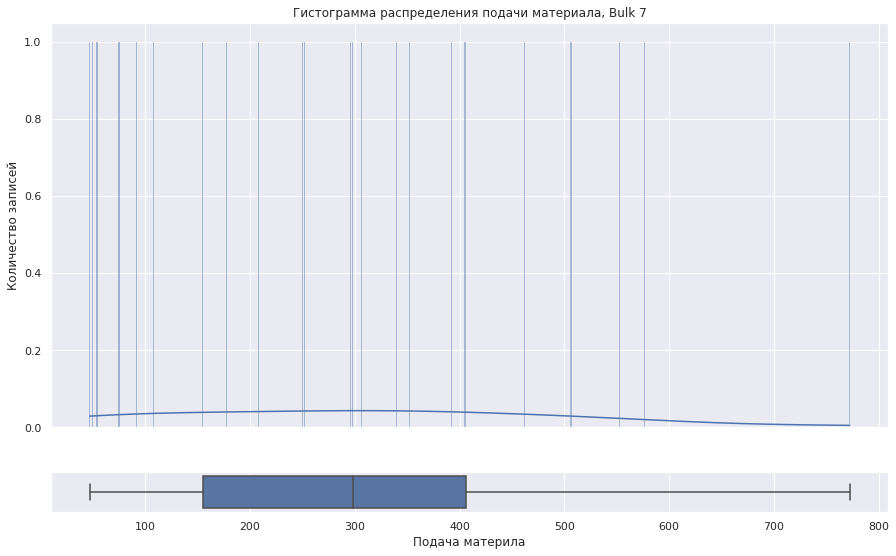

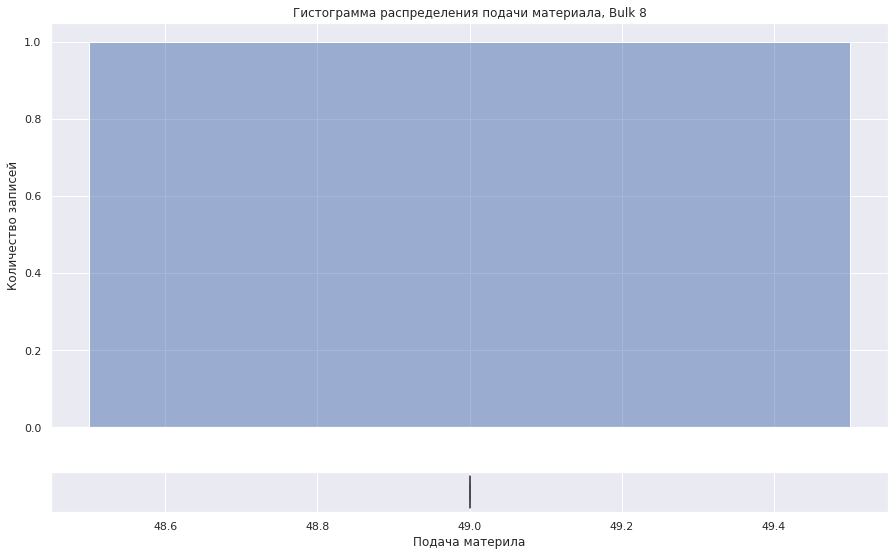

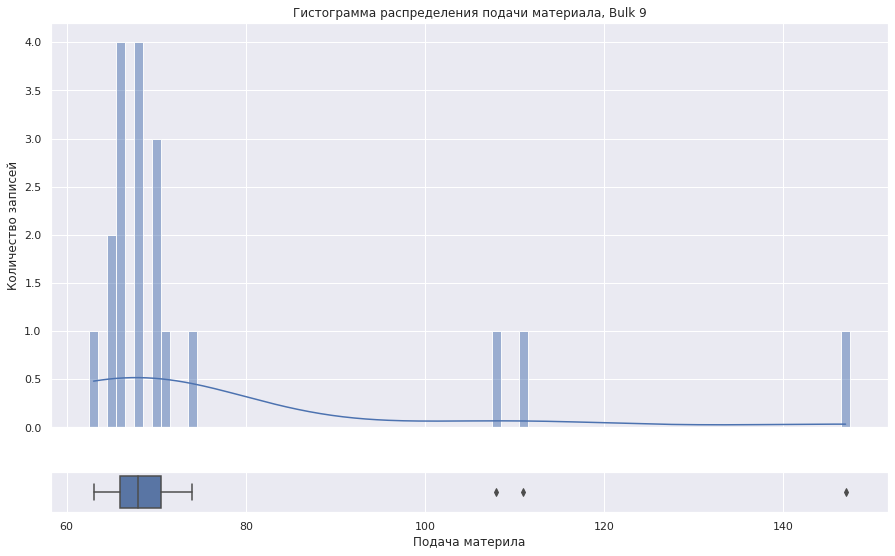

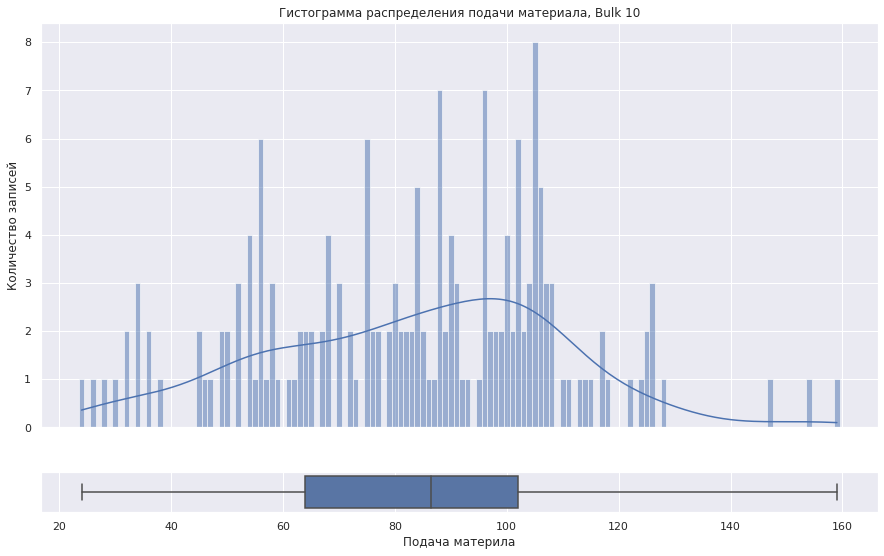

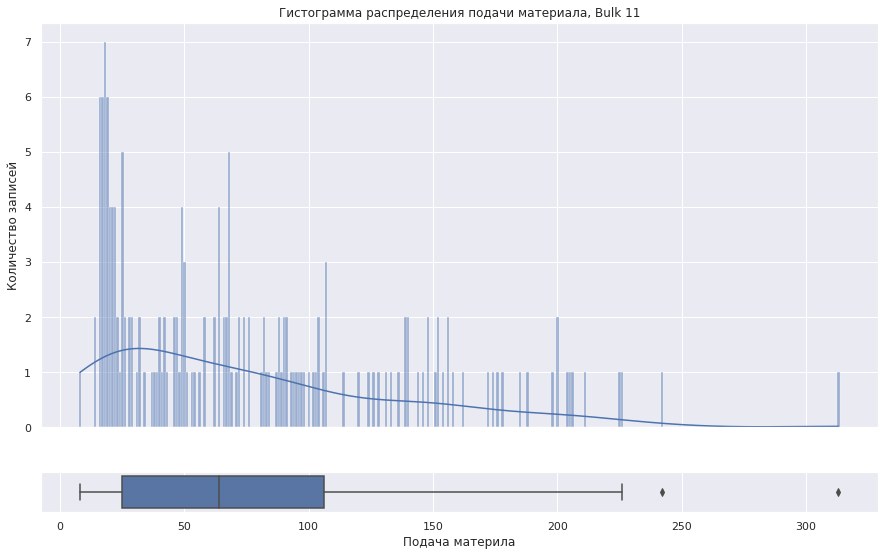

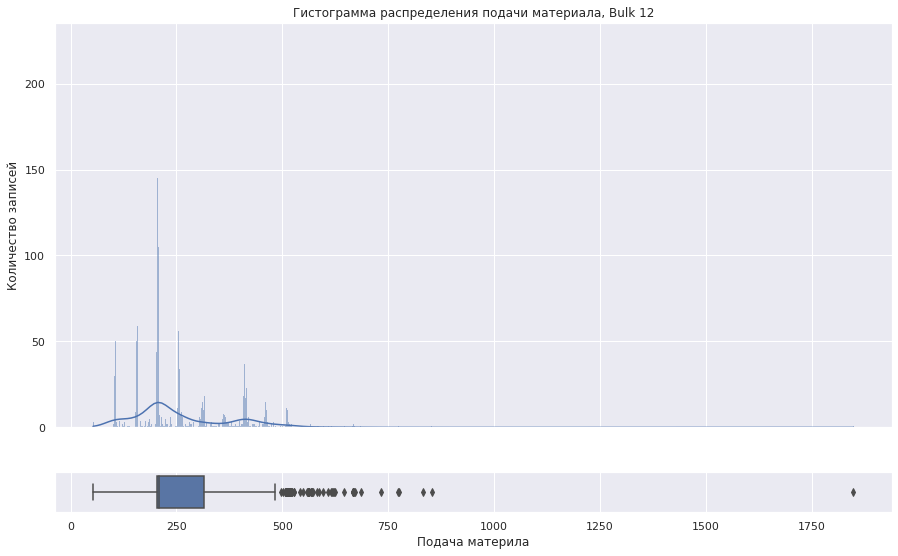

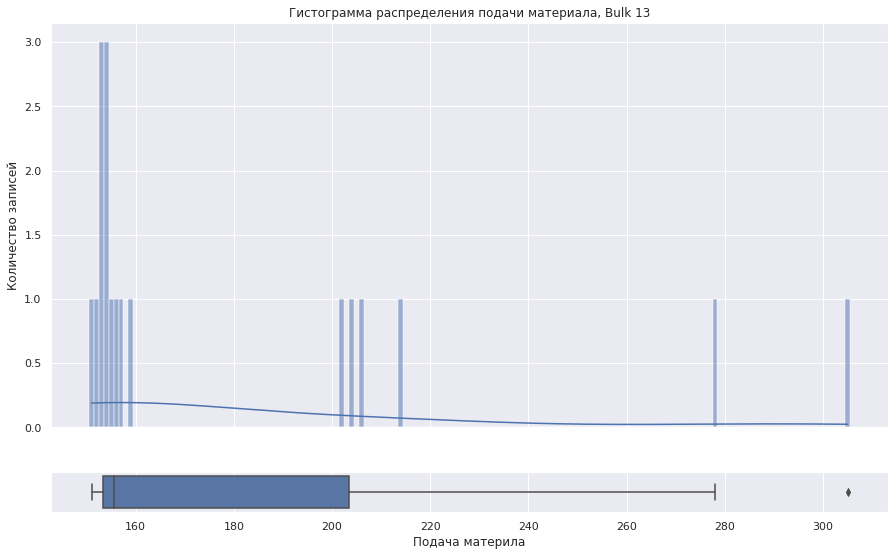

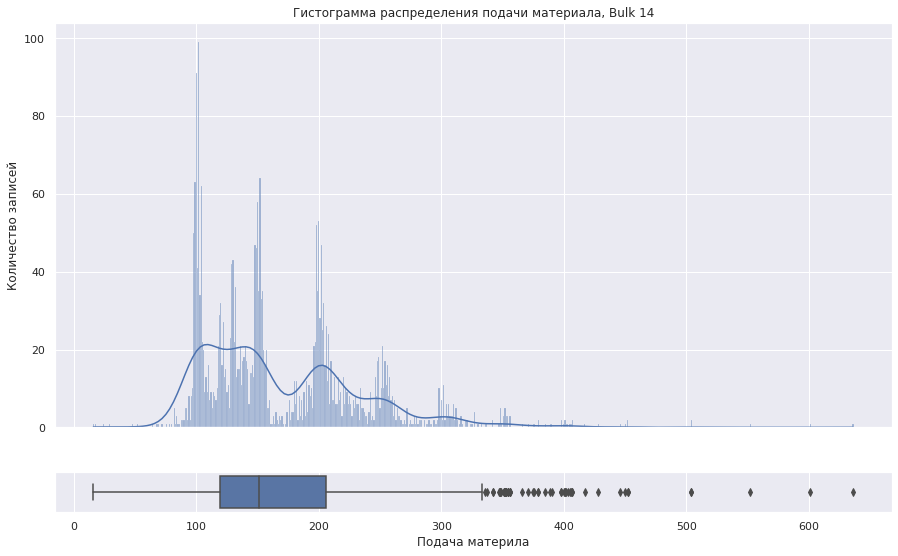

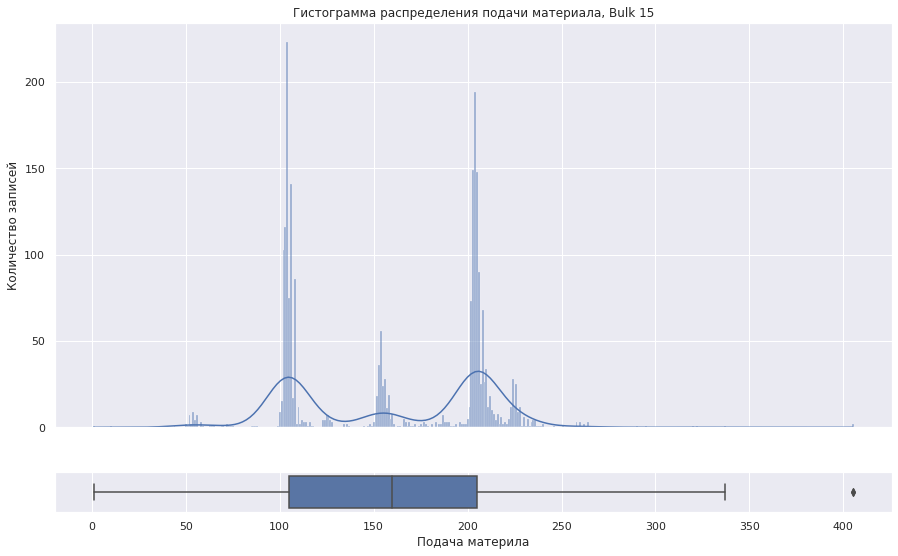

In [ ]:
for bulk in bulks:
    _, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 9), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[10,1]))
    hist = sns.histplot(data=df_bulk, x=bulk, kde=True, ax=axs_hist, discrete=True)
    box = sns.boxplot(data=df_bulk, x=bulk, orient='h', ax=axs_box)
    hist.set(title='Гистограмма распределения подачи материала, ' + bulk,
            ylabel='Количество записей')
    box.set(xlabel='Подача материла');

Гистограммы для всех материалов заметно отличаются. Некоторые материалы (например, `Bulk 8`) добавляются только в определённом количестве. Для некоторых веществ (например, для широко применяющегося `Bulk 6`) концентрации могут сильно различаться от партии к партии.

На некоторых гистограммах заметны подорзрительные значения. Возможно это выбросы, но заказчик утверждает, что эти данные надо использовать для обучения модели.

### Данные о подаче сыпучих материалов (время)

In [ ]:
df_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56


In [ ]:
df_bulk_time.key.nunique()

3129

Количество уникальных значений стоблца `key` совпадает с аналогичным количеством для таблицы `df_bulk`. Ну и хорошо.

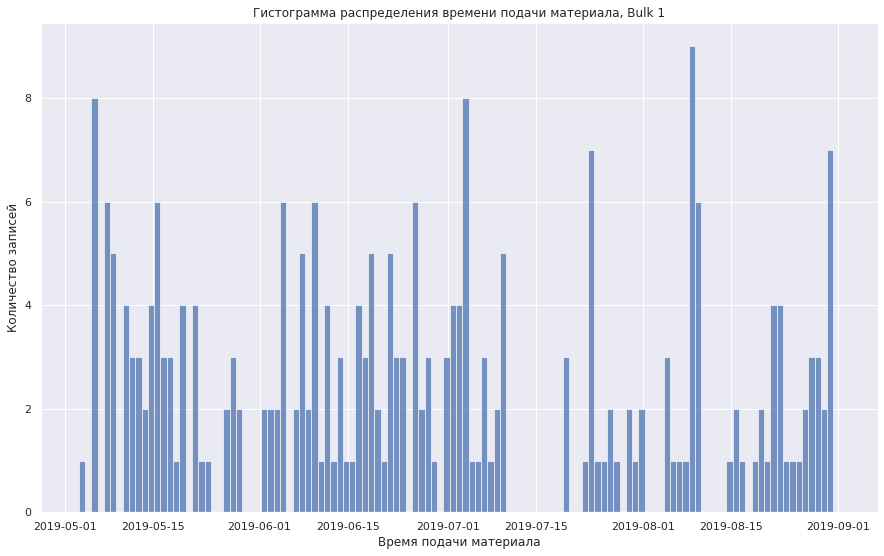

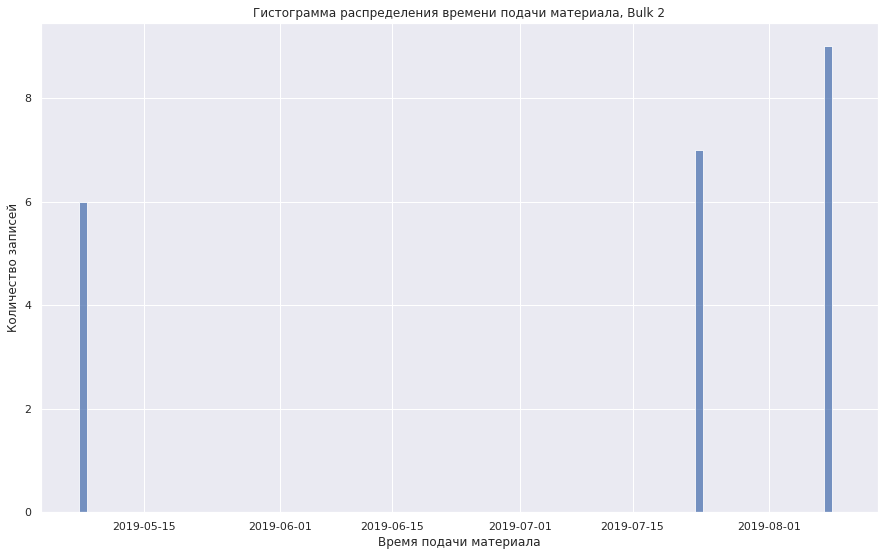

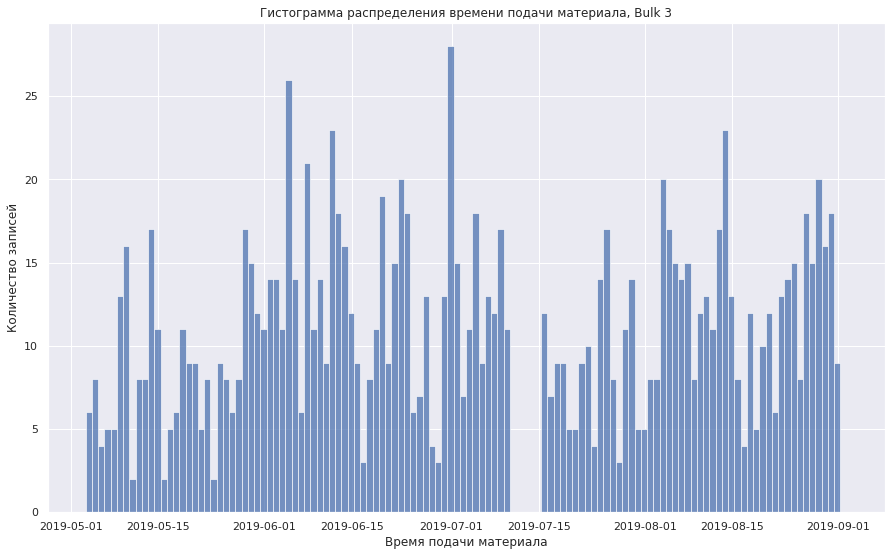

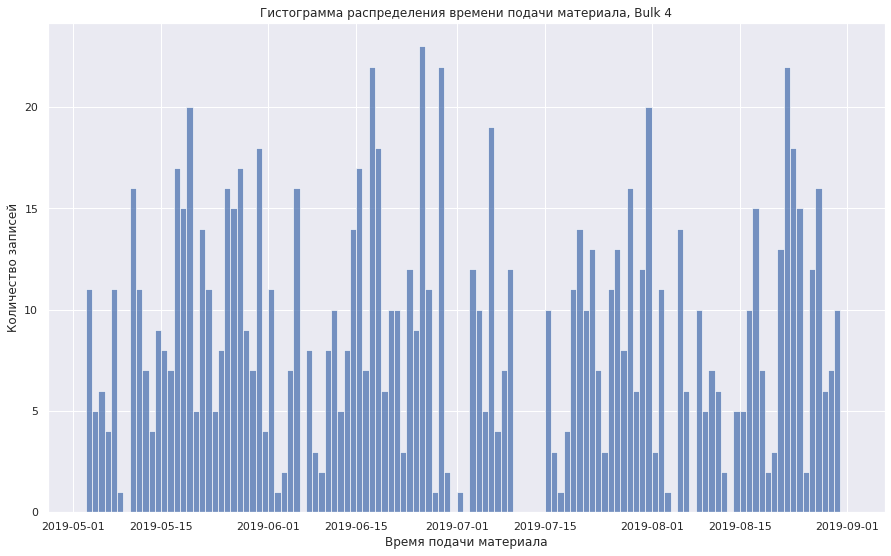

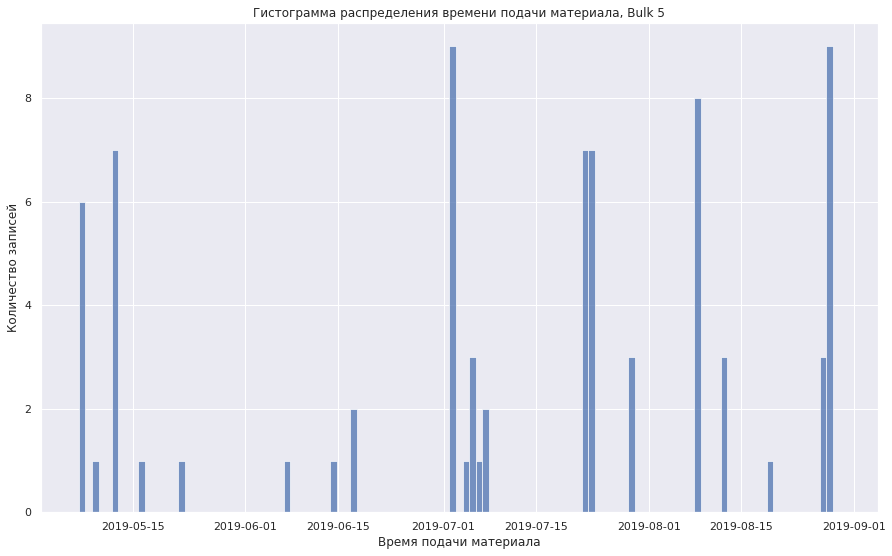

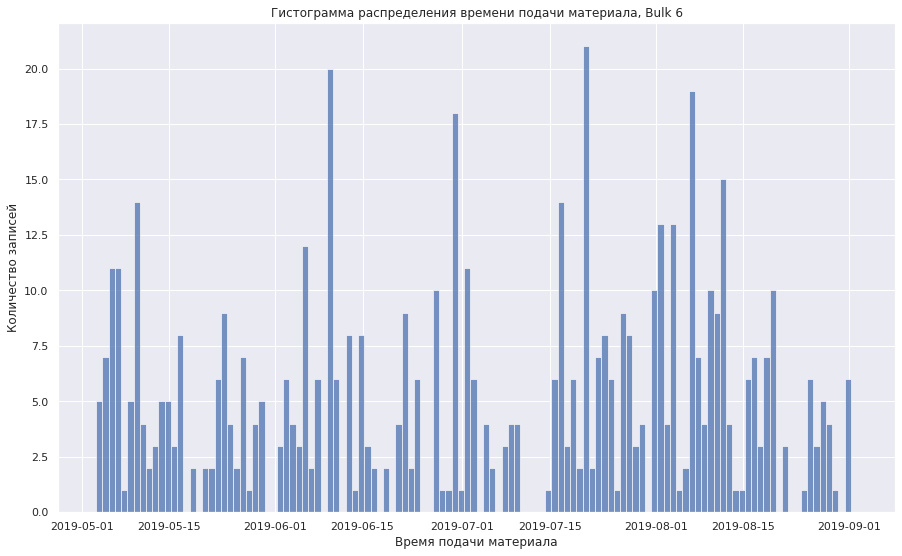

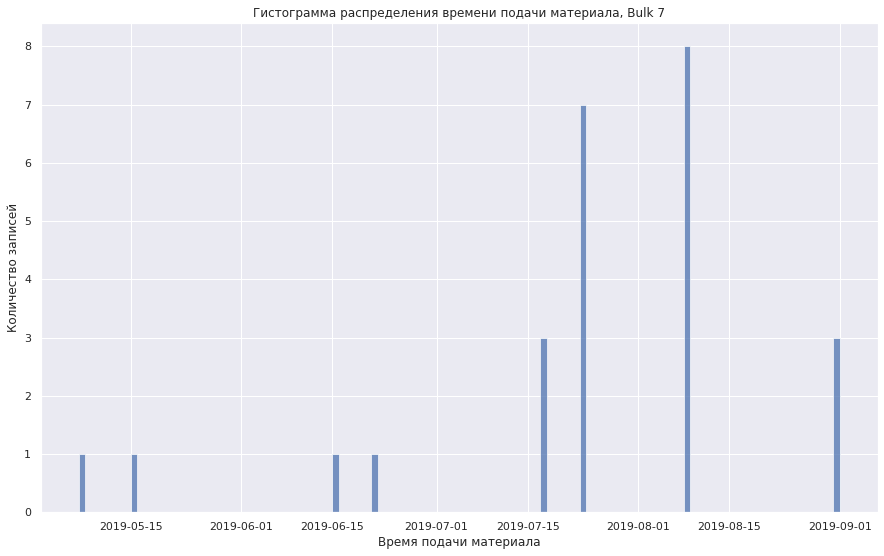

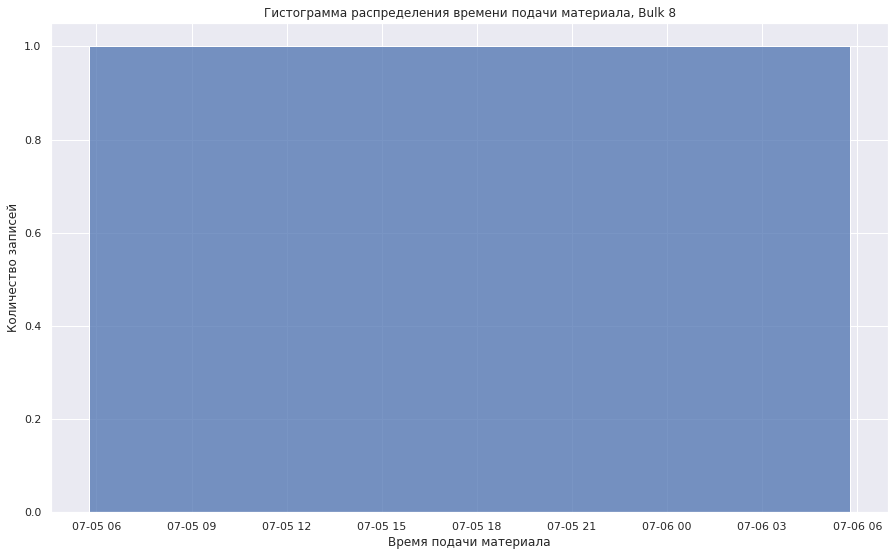

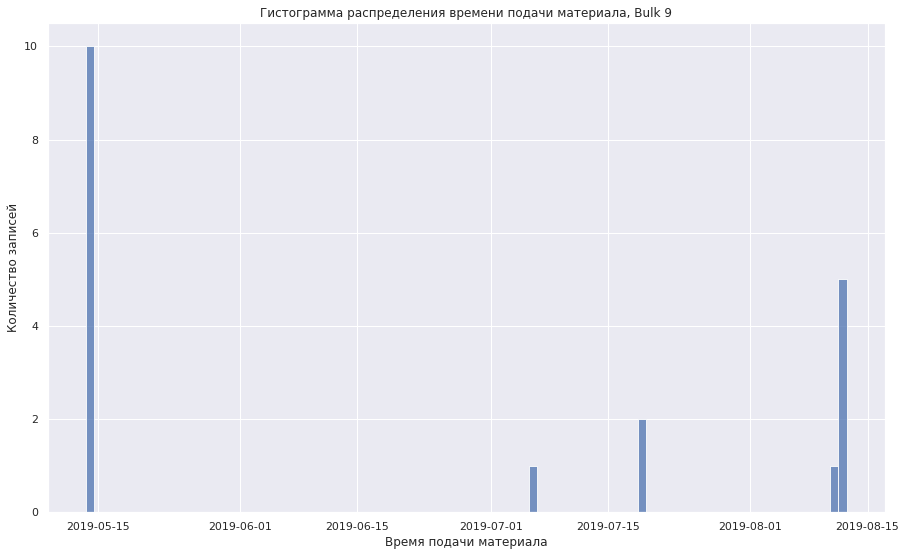

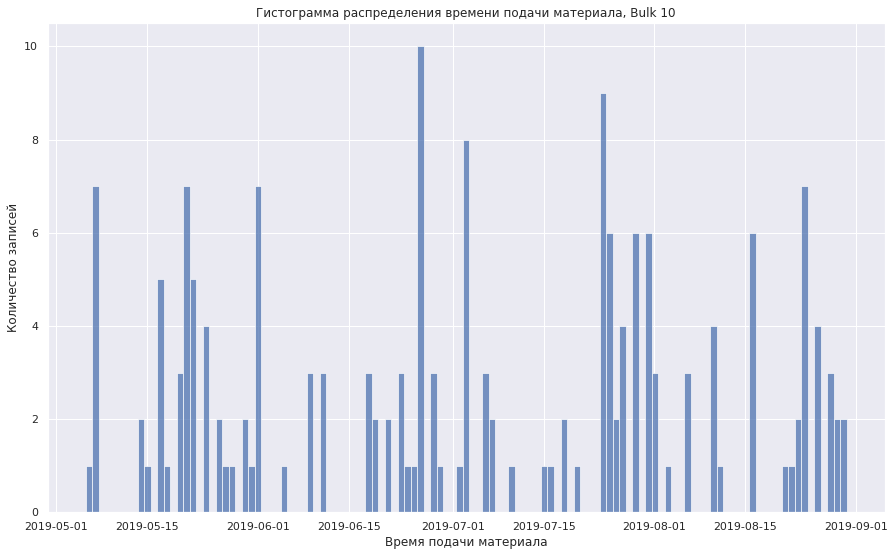

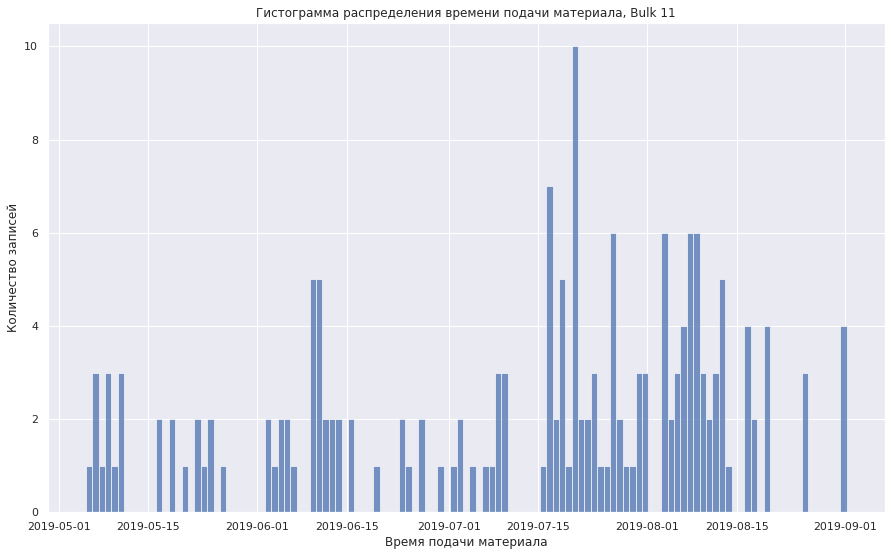

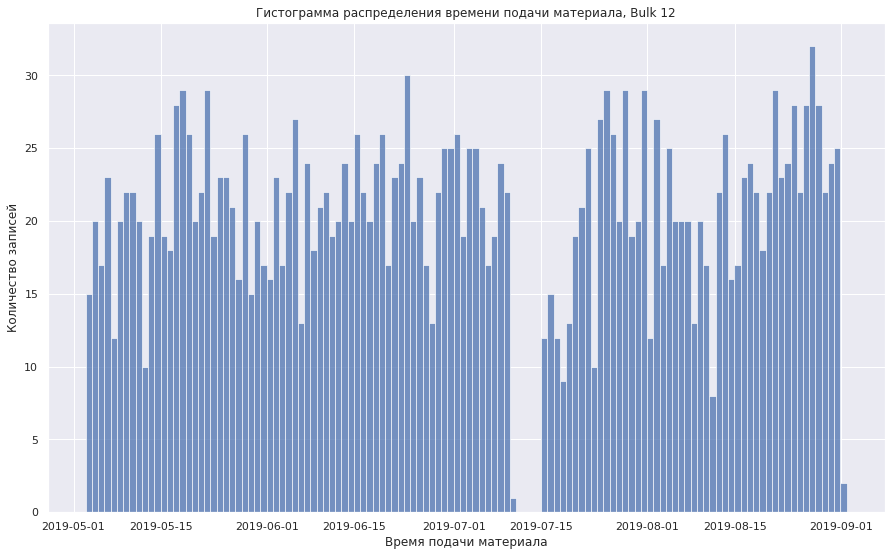

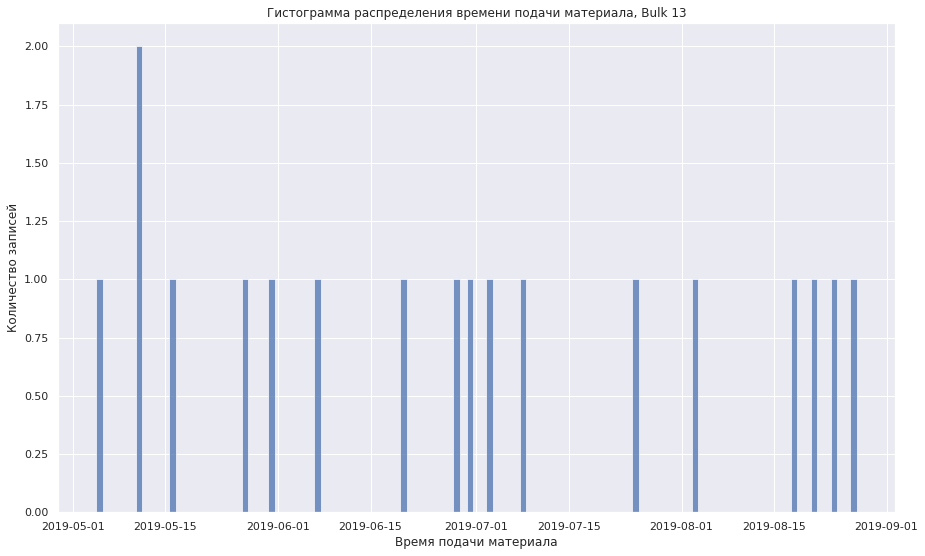

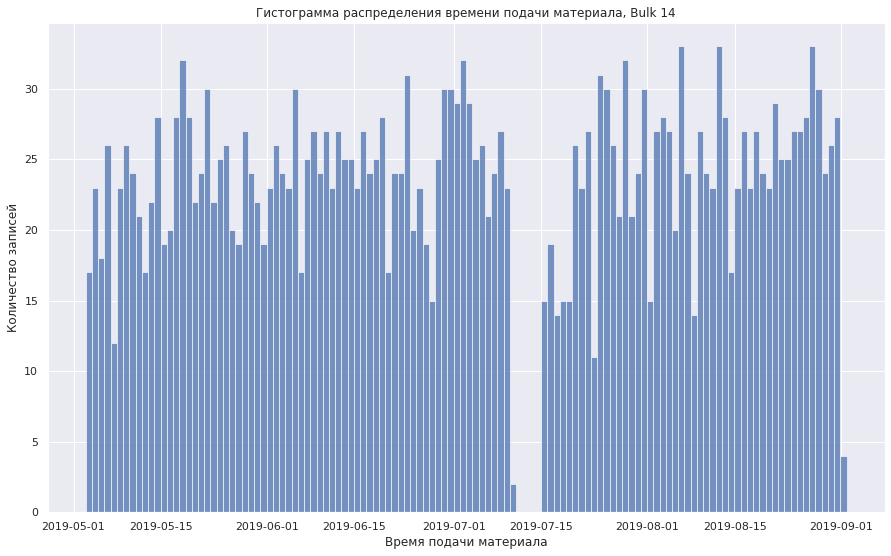

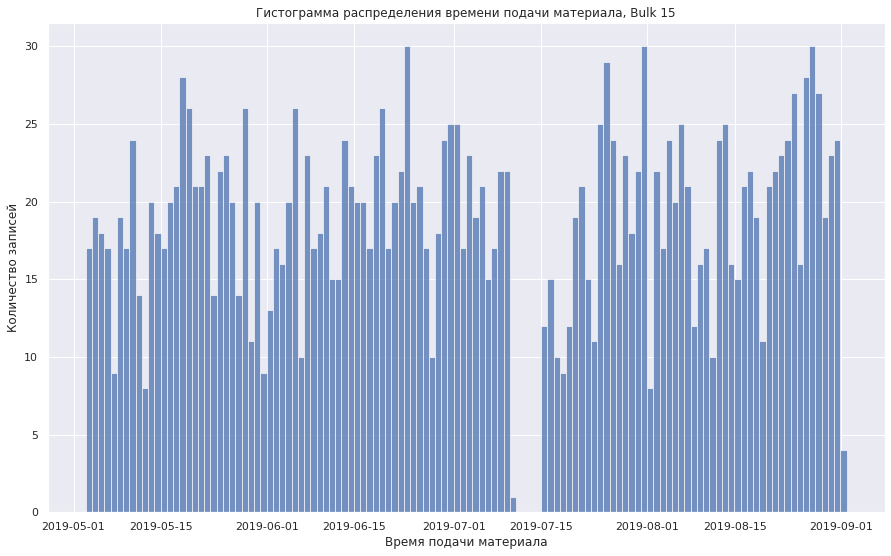

In [ ]:
for bulk in bulks:
    sns.histplot(data=df_bulk_time, x=bulk, discrete=True)\
    .set(title='Гистограмма распределения времени подачи материала, ' + bulk,
         ylabel='Количество записей',
         xlabel='Время подачи материала')
    plt.show();

На гистограммах времени подачи материала подозрительных значений не видно. Видны пропуски в данных за некоторые числа июля, которые мы заметили ранее в таблице `df_arc`.

### Данные о продувке сплава газом

In [ ]:
df_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [ ]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [ ]:
df_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [ ]:
df_gas.key.unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

In [ ]:
df_gas.key.nunique()

3239

In [ ]:
df_bulk.key.nunique()

3129

Все значения в колонке `key` уникальны. Всего у нас 3239 уникальных значений от 1 до 3241. Интересно, что количество уникальных ключей не совпадает с их количеством в таблице `df_bulk`. 

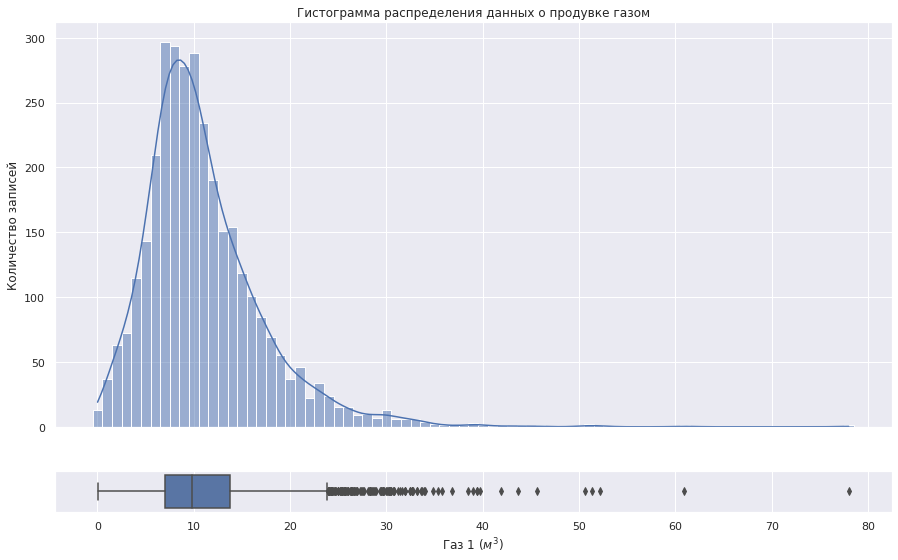

In [ ]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 9), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[10,1]))
hist = sns.histplot(data=df_gas, x='Газ 1', kde=True, ax=axs_hist, discrete=True)
box = sns.boxplot(data=df_gas, x='Газ 1', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения данных о продувке газом',
         ylabel='Количество записей')
box.set(xlabel='Газ 1 $(м^3)$');

Гистограмма снова напоминает распределение Пуассона. Среднее — 11.0, стандартное отклонение —  6.22.

### Результаты измерения температуры

In [ ]:
df_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [ ]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [ ]:
df_temp.describe(datetime_is_numeric=True)

,key,Время замера,Температура
count,15907.000000,15907,13006.000000
mean,1607.880870,2019-07-02 09:55:01.000942848,1591.840920
min,1.000000,2019-05-03 11:16:18,1191.000000
25%,790.000000,2019-06-01 16:24:51.500000,1581.000000
50%,1618.000000,2019-06-30 10:31:14,1591.000000
75%,2427.000000,2019-08-03 12:07:59,1601.000000
max,3241.000000,2019-09-01 04:38:08,1705.000000
std,942.212073,NaN,21.375851


In [ ]:
df_temp.key.nunique()

3216

In [ ]:
df_temp.key.value_counts().head().to_frame()

,key
46,16
1214,16
44,16
1513,16
2108,15


В столбце `key` 3216 уникальных значений. Интересно, что количество уникальных значений стоблца не совпадает ни в одной из имеющихся таблиц.

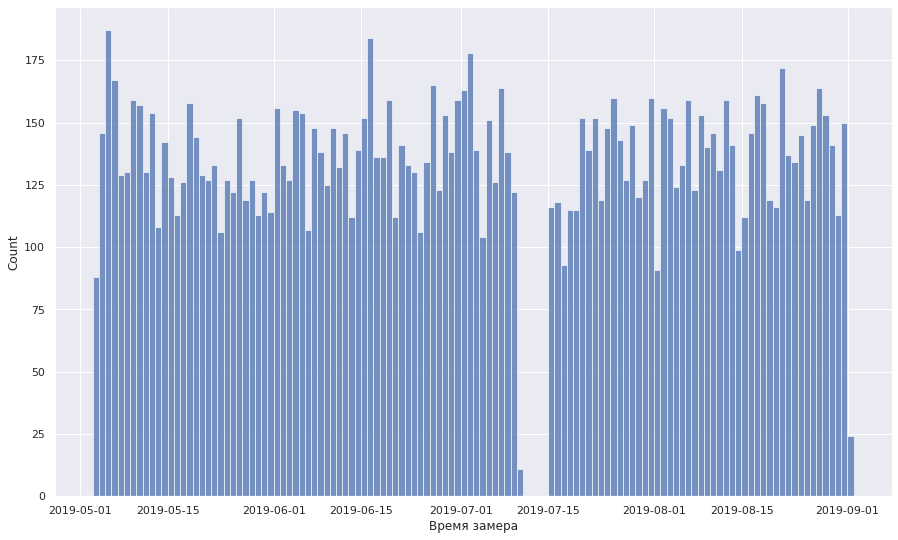

In [ ]:
sns.histplot(data=df_temp, x='Время замера', discrete=True)

Подозрительных значений не наблюдается, виден разрыв данных за 7-й месяц, как и в остальных таблицах.

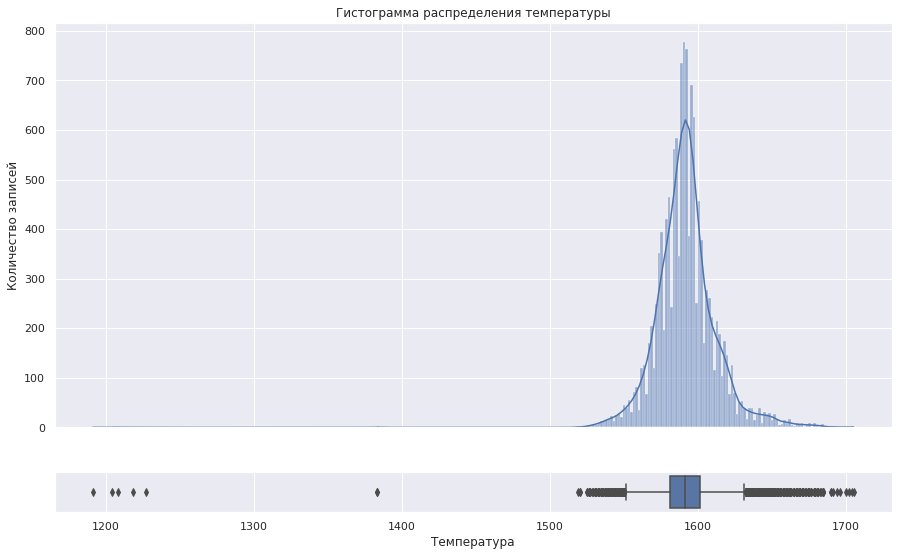

In [ ]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 9), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[10,1]))
hist = sns.histplot(data=df_temp, x='Температура', kde=True, ax=axs_hist)
box = sns.boxplot(data=df_temp, x='Температура', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения температуры',
         ylabel='Количество записей')
box.set(xlabel='Температура');

Распределение температуры похоже на нормальное с длинным левым хвостом, средним 1591, стандартным отклонением 21. Заказчик сообщил, что температура не может опускаться ниже 1500 градусов. Посмотрим на гистограмму очищенных данных.

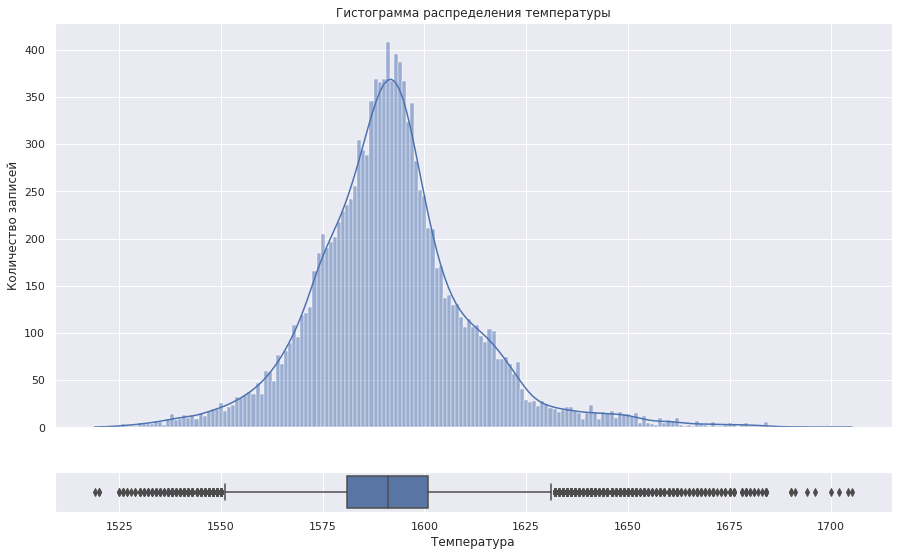

In [ ]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 9), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[10,1]))
hist = sns.histplot(data=df_temp[df_temp['Температура'] > 1500], 
                    x='Температура', kde=True, ax=axs_hist, discrete=True)
box = sns.boxplot(data=df_temp[df_temp['Температура'] > 1500], 
                  x='Температура', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения температуры',
         ylabel='Количество записей')
box.set(xlabel='Температура');

In [ ]:
df_temp[df_temp['Температура'] > 1500].describe(datetime_is_numeric=True)

,key,Время замера,Температура
count,12999.000000,12999,12999.000000
mean,1328.243942,2019-06-21 18:30:10.466035712,1592.020078
min,1.000000,2019-05-03 11:16:18,1519.000000
25%,638.000000,2019-05-26 20:04:34,1581.000000
50%,1315.000000,2019-06-19 16:58:05,1591.000000
75%,1977.500000,2019-07-18 19:38:55,1601.000000
max,3241.000000,2019-09-01 04:03:30,1705.000000
std,804.821269,NaN,19.853665


Распределение похоже на нормальное, среднее — 1592, стандартное отклонение — 20.

###  Данные о проволочных материалах (объём)

In [ ]:
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [ ]:
df_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [ ]:
df_wire.key.nunique()

3081

В столбце `key` 3081 уникальное значение.

In [ ]:
wires = df_wire.columns
wires = wires.to_list()[1:]

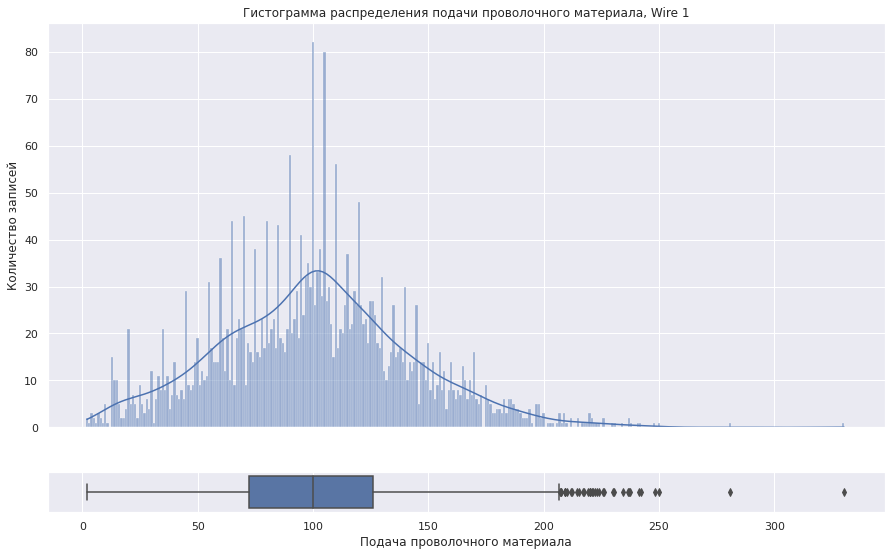

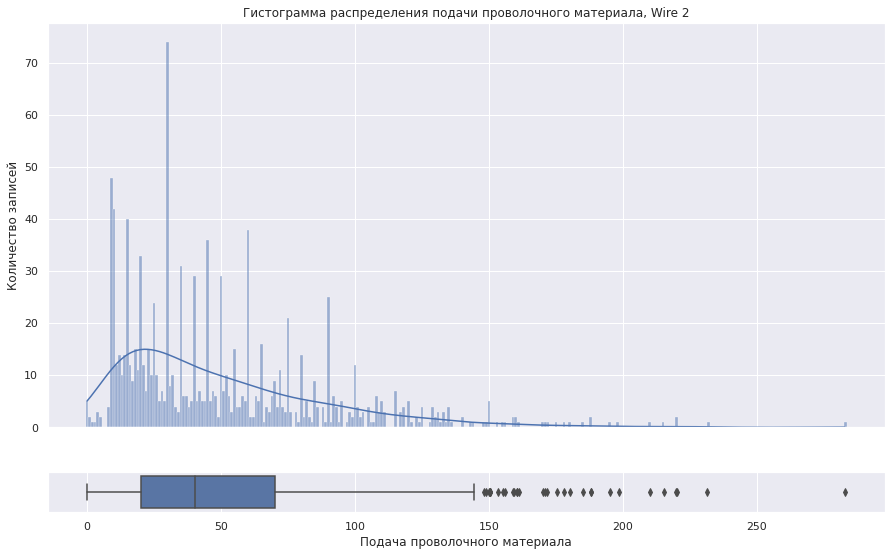

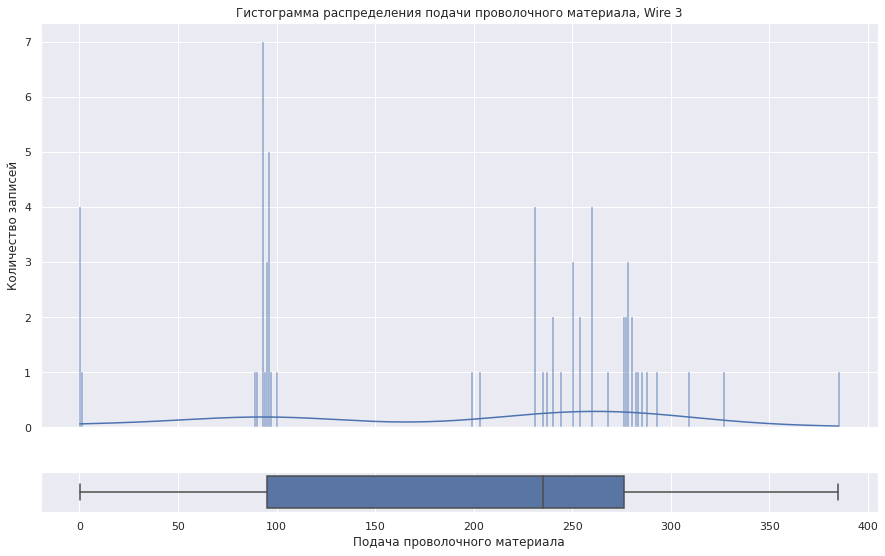

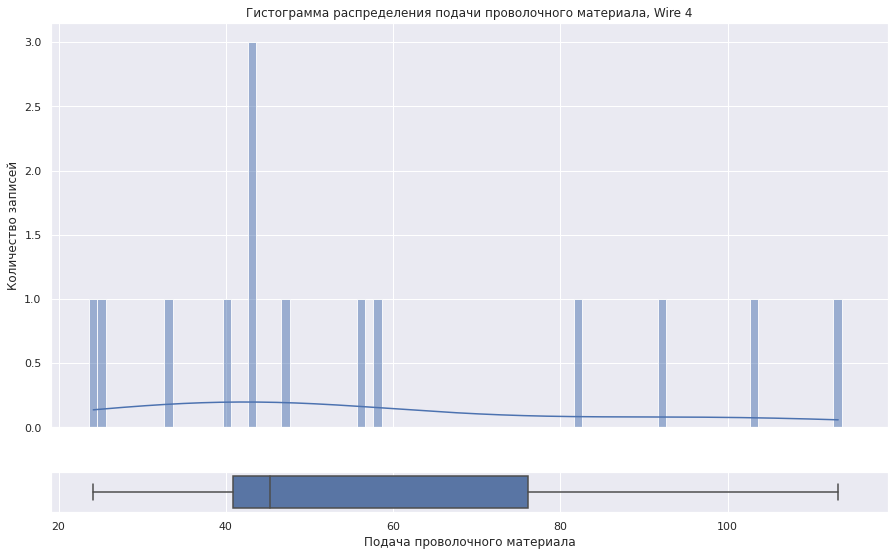

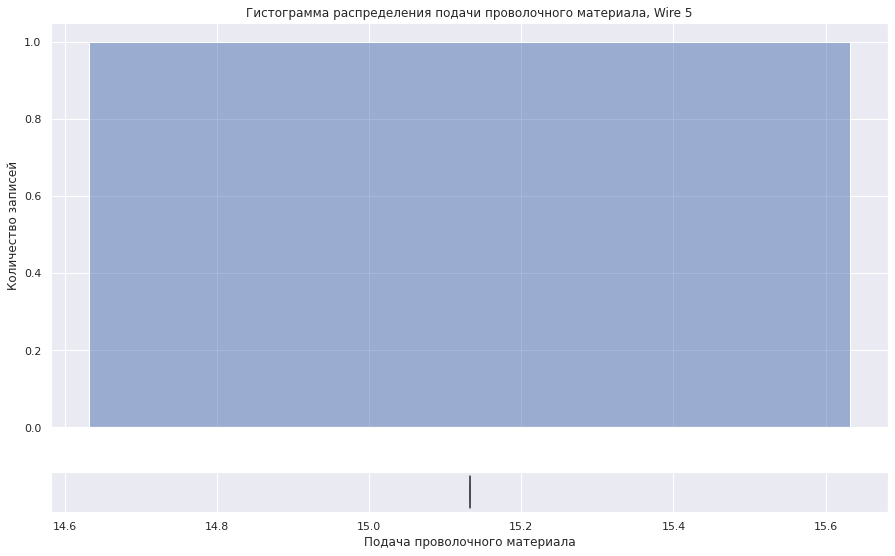

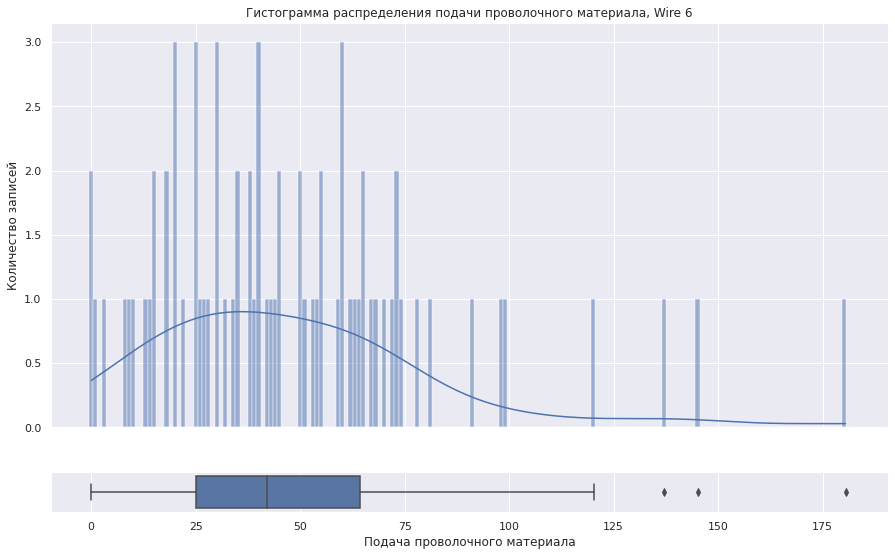

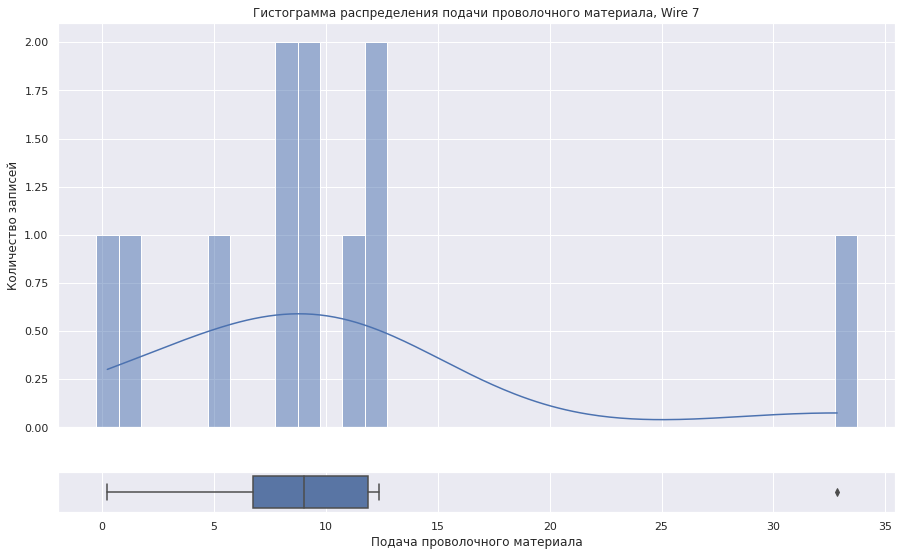

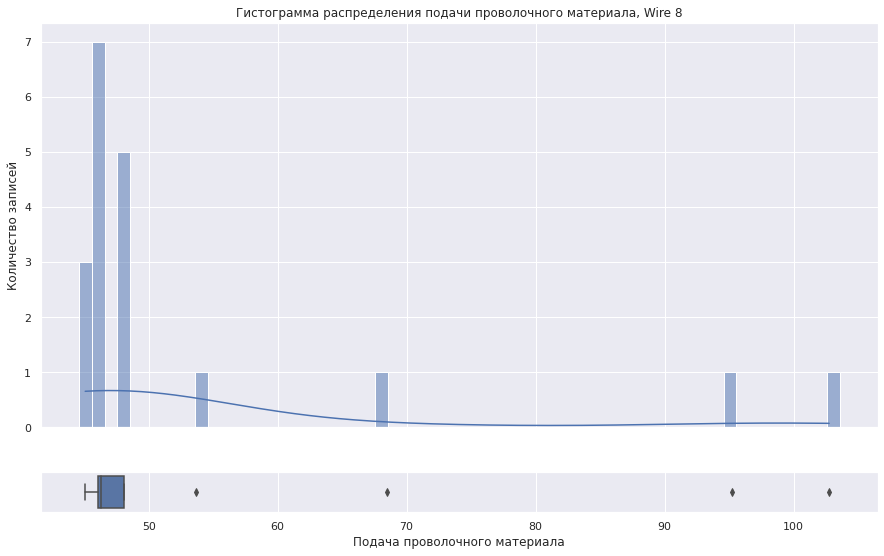

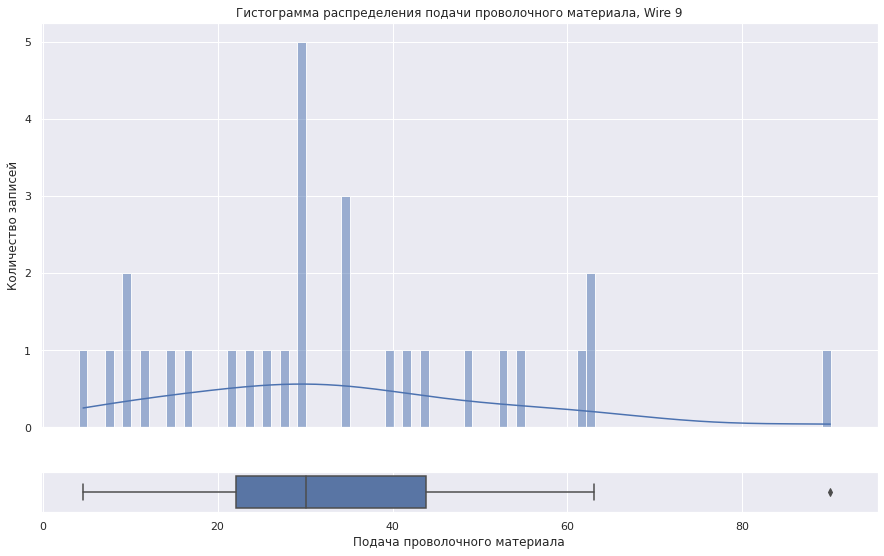

In [ ]:
for wire in wires:
    _, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 9), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[10,1]))
    hist = sns.histplot(data=df_wire, x=wire, kde=True, ax=axs_hist, discrete=True)
    box = sns.boxplot(data=df_wire, x=wire, orient='h', ax=axs_box)
    hist.set(title='Гистограмма распределения подачи проволочного материала, ' + wire,
            ylabel='Количество записей')
    box.set(xlabel='Подача проволочного материала');

Гистограммы выглядят правдоподобно, есть несколько подозрительных значений, но их немного и они вполне могут быть валидными.

### Данные о проволочных материалах (время)

In [ ]:
df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [ ]:
df_wire_time.key.nunique()

3081

В столбце `key` 3081 уникальное значение, что совпдает с таблицей `df_wire`. Вот и славненько.

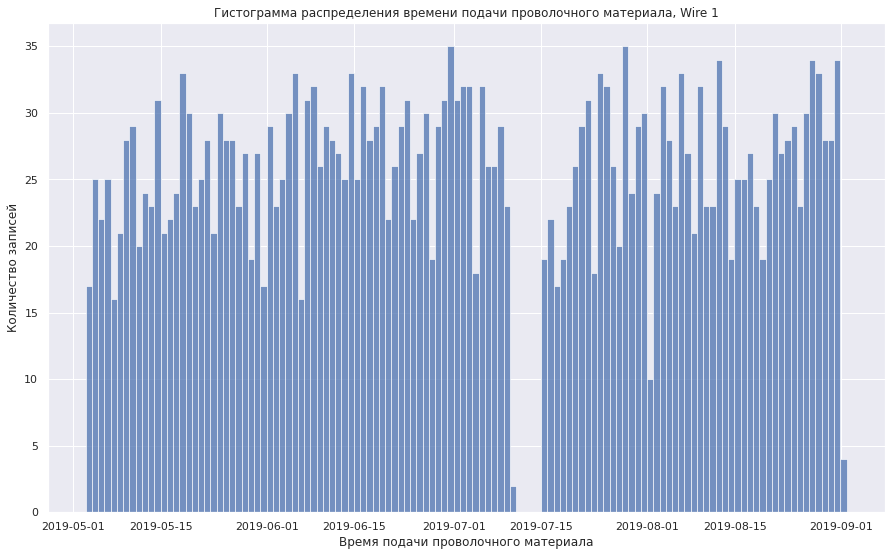

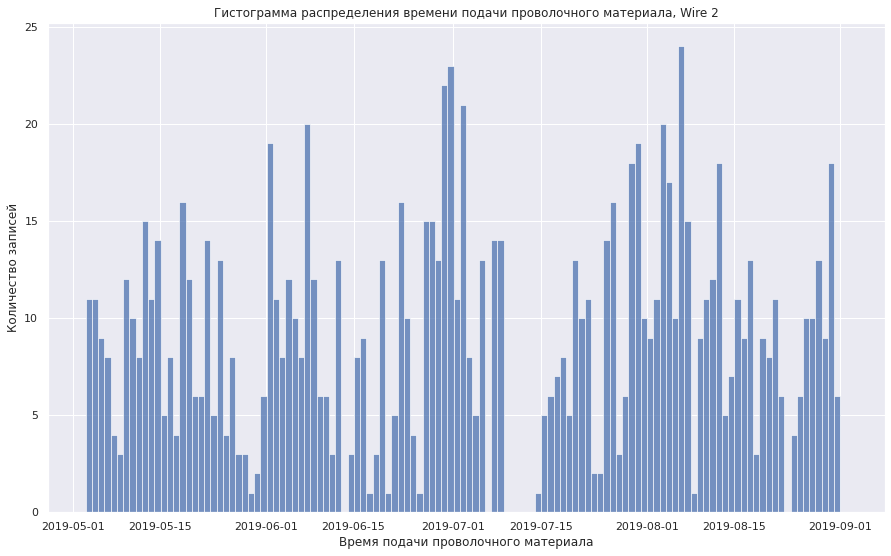

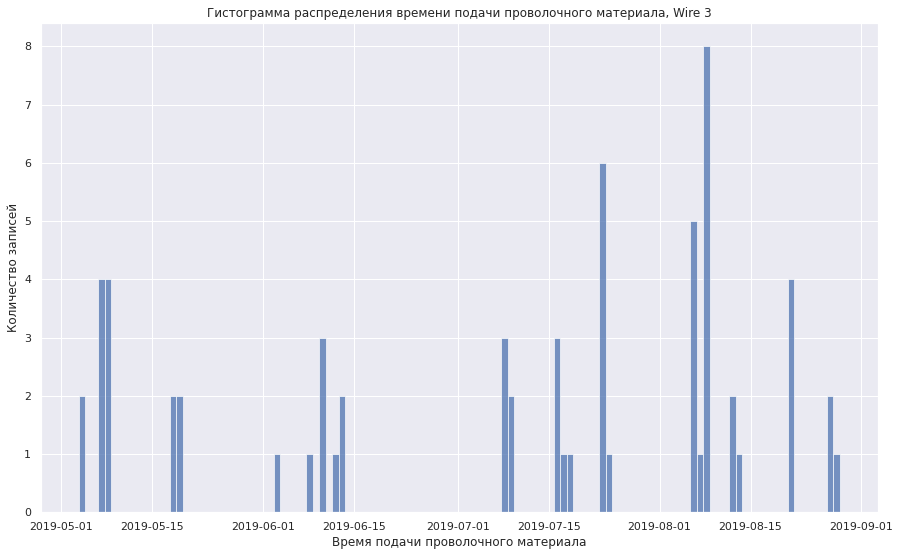

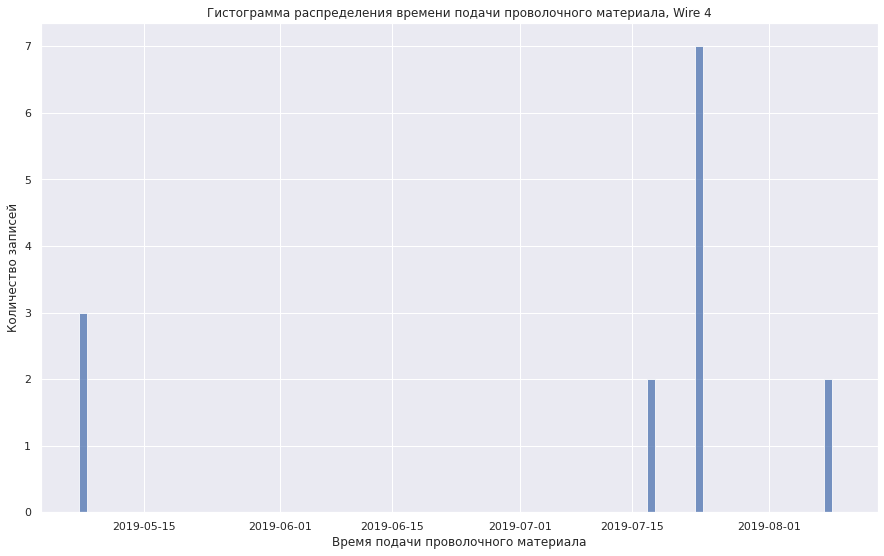

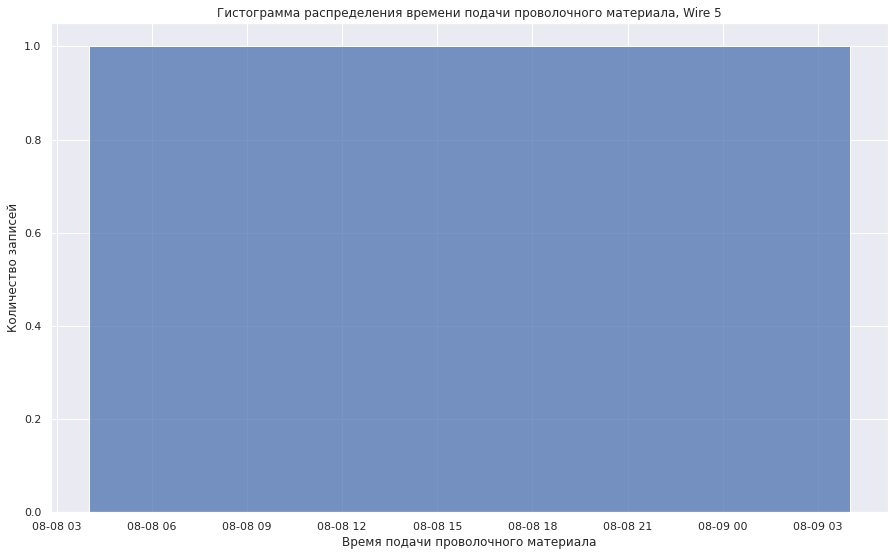

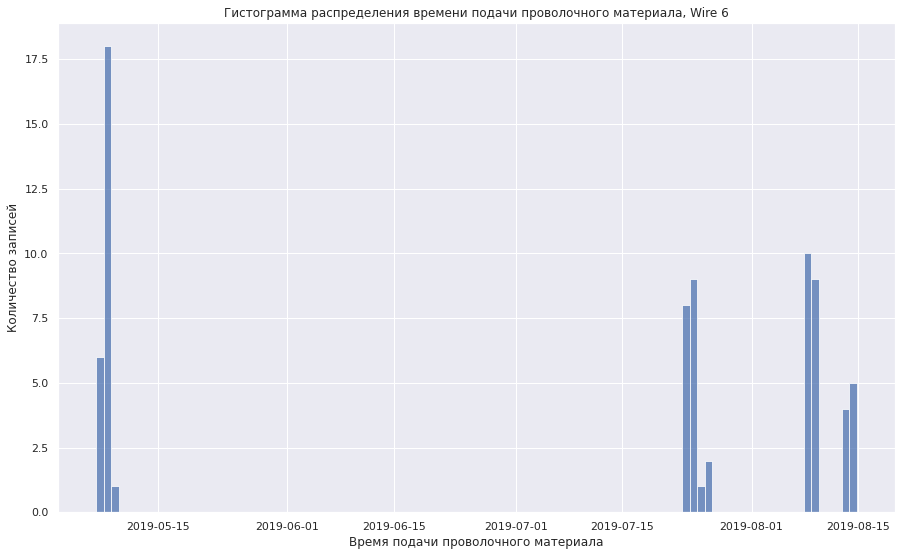

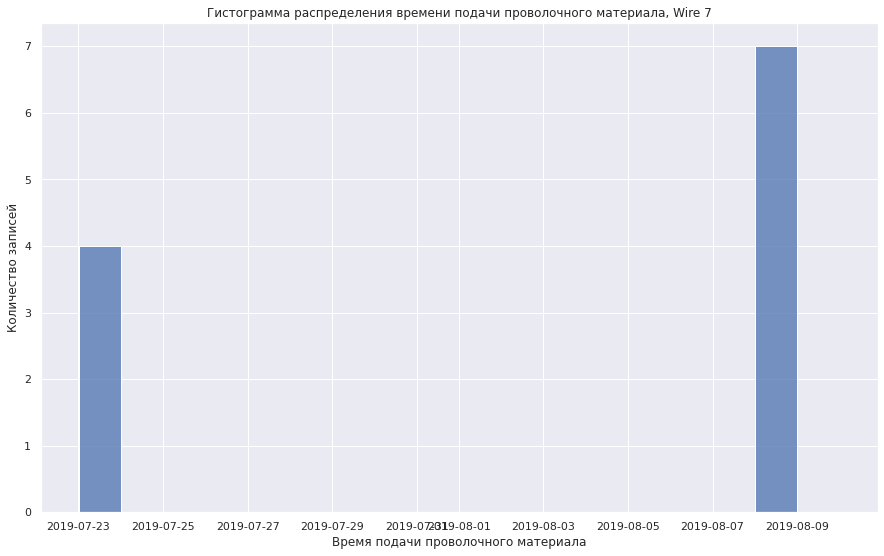

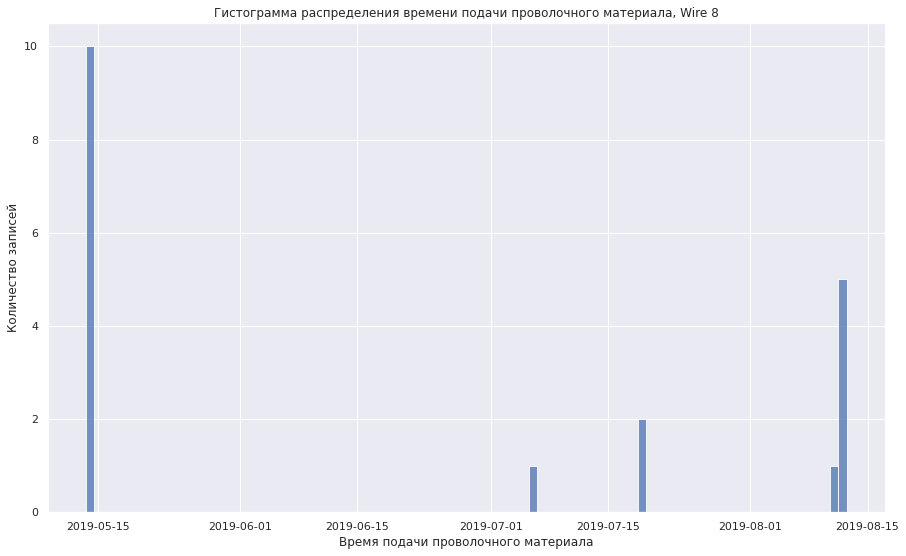

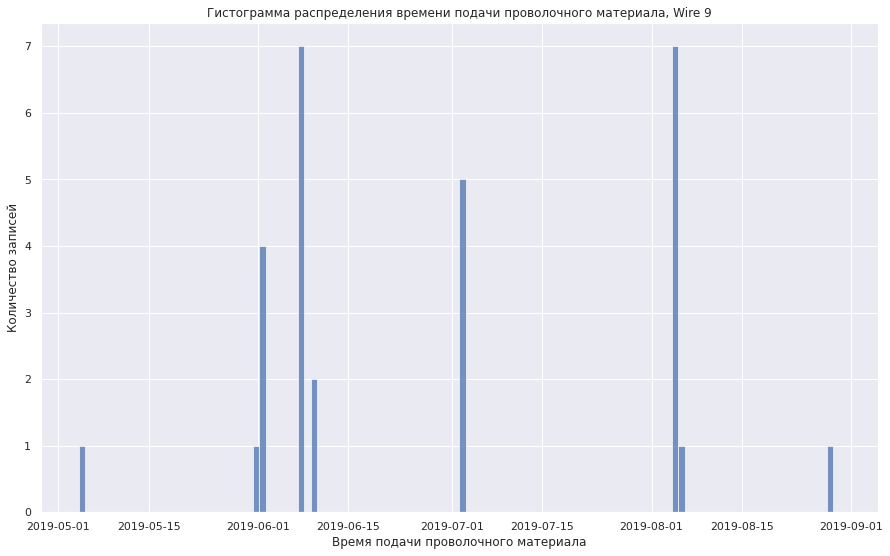

In [ ]:
for wire in wires:
    sns.histplot(data=df_wire_time, x=wire, discrete=True)\
    .set(title='Гистограмма распределения времени подачи проволочного материала, ' + wire,
         ylabel='Количество записей',
         xlabel='Время подачи проволочного материала')
    plt.show();

Каких-то заметных проблем в данных нет, все даты выглядят правдоподобно и согласуются с ранее изученными данными.

### Промежуточные выводы

Мы провели исследовательский анализ данных, в ходе которого было выявлено несколько проблем, которые необходимо решить до этапа обучения модели.
1. Во всех таблицах были выявлены пропуски данных. Природа части пропусков известна от заказчика.
2. Во всех колонках, содержащих данные о времени совершения операций, отсутствует информация о периоде 11, 12, 13 июля;
3. В некоторых колонках были выявлены подозрительные значения. Они могли появиться в данных например, в результате сбоя измерительного оборудования;
4. Были выявлены замеры температуры менее 1500 градусов. Эти данные необходимо будет удалить.
5. Была выявлена партия с отрицательной реактивной мощностью. Данные этой партии нужно будет удалить.
4. Во всех таблицах количество уникальных значений в столбце `key` различается. При формировании единой таблицы обучающих признаков необходимо это учитывать.

## Подготовка данных для обучения модели

Подготовим данные для обучения. Удалим выбросы, соберём данные в единую таблицу, выделим обучающие и целевой признаки.

### Удаление выбросов

Начнём с удаления выбросов. На этапе исследовательского анализа данных мы обнаружили:
* пропуски данных в таблице температур;
* значения температуры ниже 1500 градусов;
* отрицательную реактивную мощность.

Также по условию заказчика мы не можем использовать в моделировании сведения о промежуточных температурах.


Удалим все промежуточные температуры.

In [ ]:
def temp_first_and_final(df):
    dfs_list = []
    for key in df['key'].unique():
        sorted = df[df['key'] == key].sort_values(by='Время замера').copy()
        dfs_list.append(pd.concat([sorted.head(1), sorted.tail(1)]))
    return pd.concat(dfs_list)

In [ ]:
df_temp = temp_first_and_final(df_temp)

Удалим все ключи, для которых есть пропуски данных в таблице температур.

In [ ]:
na_keys = df_temp[df_temp['Температура'].isna()]['key'].unique()

In [ ]:
df_temp = df_temp[~df_temp['key'].isin(na_keys)].copy()

Удалим все ключи, в которых была зафиксирована аномально низкая температура.

In [ ]:
low_temp_key = df_temp[df_temp['Температура'] < 1500]['key'].unique()

In [ ]:
df_temp = df_temp[~df_temp['key'].isin(low_temp_key)].copy()

Удалим ключ с отрицательной реактивной мощностью.

In [ ]:
neg_key = df_arc[df_arc['Реактивная мощность'] < 0]['key'].unique()

In [ ]:
df_arc = df_arc[~df_arc['key'].isin(neg_key)].copy()

Обновим индексы для таблиц `df_temp` и `df_arc`.

In [ ]:
df_temp = df_temp.reset_index(drop=True)

In [ ]:
df_arc = df_arc.reset_index(drop=True)

Посмотрим на получившиеся гистограммы температуры и реактивной мощности.

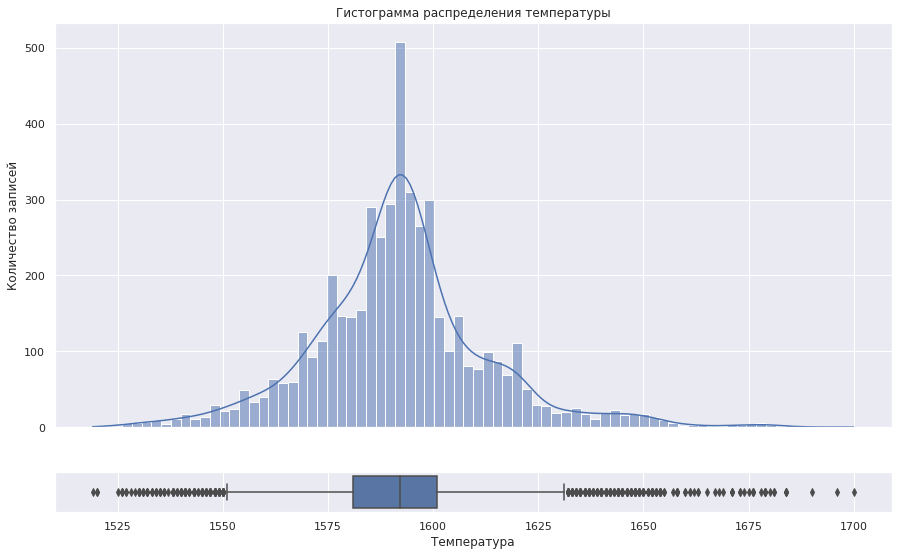

In [ ]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 9), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[10,1]))
hist = sns.histplot(data=df_temp, x='Температура', kde=True, ax=axs_hist)
box = sns.boxplot(data=df_temp, x='Температура', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения температуры',
         ylabel='Количество записей')
box.set(xlabel='Температура');

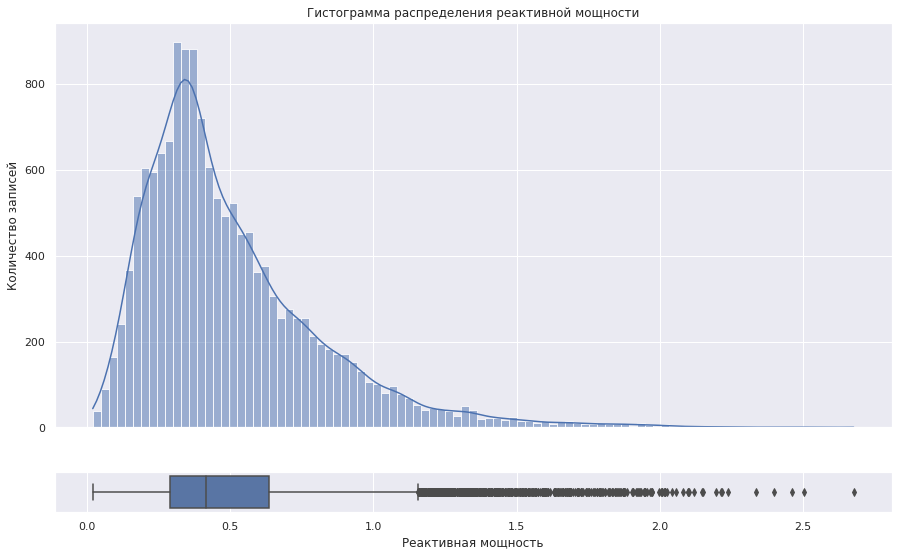

In [ ]:
_, [axs_hist, axs_box] = plt.subplots(2, 1,
                                     figsize=(15, 9), 
                                     sharex=True,
                                     gridspec_kw=dict(height_ratios=[10,1]))
hist = sns.histplot(data=df_arc, x='Реактивная мощность', kde=True, ax=axs_hist)
box = sns.boxplot(data=df_arc, x='Реактивная мощность', orient='h', ax=axs_box)
hist.set(title='Гистограмма распределения реактивной мощности',
         ylabel='Количество записей')
box.set(xlabel='Реактивная мощность');

Выбросы и пропуски удалены, приступим к объединению таблиц.

### Формирование единой таблицы

Начнём с того, что таблицу `df_temp` преобразуем к удобному для обучения виду: из временных данных получим разницу по времени между первым и последним замерами, начальную и итоговую температуру перенесём в отдельные столбцы.

In [ ]:
def convert_temp(df):
    dfs_list = []
    for key in df['key'].unique():
        tmp = df[df['key'] == key].reset_index(drop=True)

        time_delta = (tmp.loc[1, 'Время замера'] - 
                      tmp.loc[0, 'Время замера']).seconds
        temp_init = tmp.loc[0, 'Температура']
        temp_fin = tmp.loc[1, 'Температура']

        dfs_list.append(
            [key, time_delta, temp_init, temp_fin]
        )
    return pd.DataFrame(
        dfs_list,
        columns=['key', 'Время между замерами (сек)',
                 'Начальная температура',
                 'Итоговая температура']
    )

In [ ]:
df_temp = convert_temp(df_temp)

Преобразуем таблицу `df_arc`. Пересчитаем активную мощность в энергию. Воспользуемся формулой $E = P \cdot \Delta t$. Затем просуммируем всю энергию для каждого ключа.

In [ ]:
df_arc['Время нагрева (сек)'] = (df_arc['Конец нагрева дугой'] - 
                           df_arc['Начало нагрева дугой']).dt.seconds

In [ ]:
df_arc['Энергия'] = df_arc['Активная мощность'] * df_arc['Время нагрева (сек)']

In [ ]:
df_arc = df_arc.groupby('key').agg({'Энергия': sum})

Объединим таблицы `df_temp` и `df_arc`. Будем производить объединение по ключам, будем учитывать только те ключи, которые есть в обоих таблицах.

In [ ]:
df = pd.merge(left=df_temp, right=df_arc, how='inner', on='key')

Добавим таблицу `df_bulk`. Для удобства дальнейшей работы заменим пропуски данных нулями (материал не подавался).

In [ ]:
df = pd.merge(left=df, right=df_bulk.fillna(value=0), how='inner', on='key')

Время подачи материала для нас роли не играет, поэтому таблицу `df_bulk_time` подключать не будем. Добавим таблицу `df_gas`.

In [ ]:
df = pd.merge(left=df, right=df_gas, how='inner', on='key')

Добавим таблицу `df_wire`. Пропуски данных заменим нулями (проволочный материал не подавался).

In [ ]:
df = pd.merge(left=df, right=df_wire.fillna(value=0), how='inner', on='key')

Данные о времени подачи проволочного материала нам не пригодятся, поэтому не будем добавлять их в единую таблицу.

Данные объединены, посмотрим на корреляции.

In [ ]:
corr = df.corr()

In [ ]:
sns.set(rc={'figure.figsize': (15, 15)})

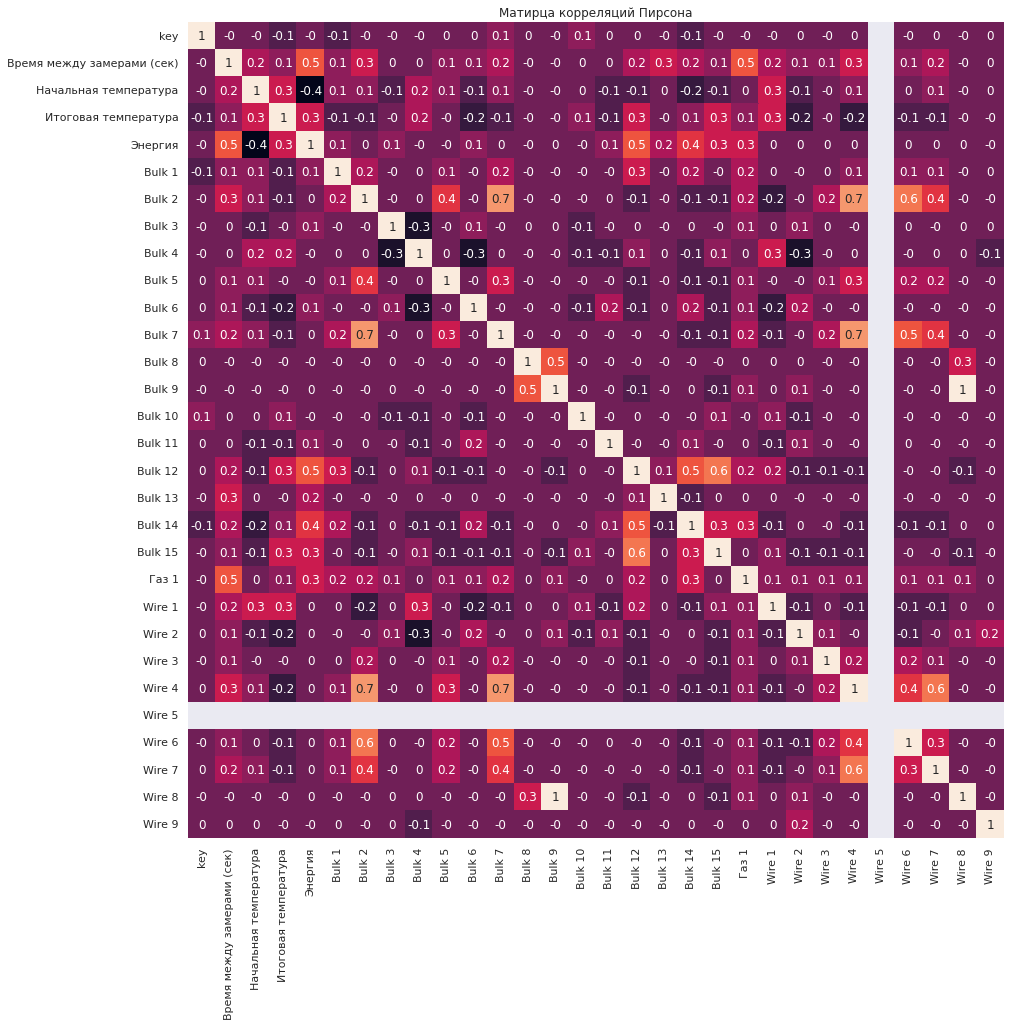

In [ ]:
sns.heatmap(data=corr.round(1), annot=True, square=True,
            cbar=False)\
.set(title='Матирца корреляций Пирсона');

Построим аналогичную матрицу корреляций по критерию $\phi_k$.

In [ ]:
phik_martrix = df.phik_matrix(interval_cols=df.columns)

Not enough unique value for variable Wire 5 for analysis 1. Dropping this column


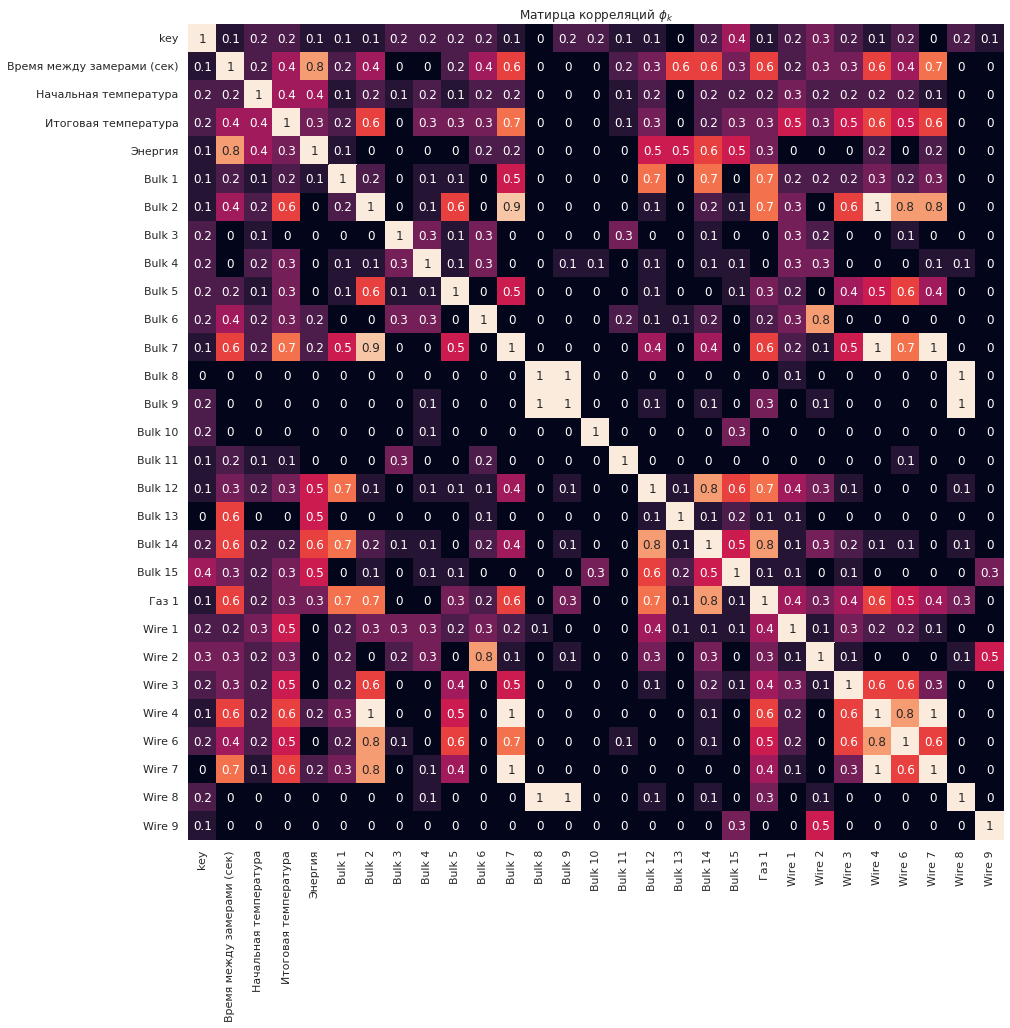

In [ ]:
sns.heatmap(data=phik_martrix.round(1), annot=True, square=True,
            cbar=False)\
.set(title='Матирца корреляций $\phi_k$');

Критерий Пирсона не выявил сильных линейных корреляций с целевым признаком. На матрице для критерия $\phi_k$ видны относительно сильные (до 0.7) корреляции между подачей некоторых материалов (например, `Bulk 7`), проволок (например, `Wire 4` и `Wire 7`) и целевым признаком. Интересно, будут ли эти признаки важны при обучении моделей.

Итак, мы собрали нужные нам данные, подготовили их. Пришло время сформировать таблицы обучающих и целевого признаков, разделить их на обучающие и тестовые выборки.

### Формирование выборок

Разделим данные на таблицы обучающих и целевого признаков.

In [ ]:
X = df.drop(['Итоговая температура', 'key'], axis=1)
y = df['Итоговая температура']

Теперь разделим их на обучающую и тестовую выборки. На тестовую выборку отведём 25 процентов имеющихся данных.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=RANDOM_STATE)

### Промежуточные выводы

Для подготовки данных к обучению мы удалили значения, которые по согласованию с заказчиком считаются выбросами. Затем мы обработали данные и сформировали дополнительные признаки: рассчитали энергию, переданную сплаву в результате нагрева и время, прошедшее между замерами температуры. Полученные таблицы мы объединили в одну, при этом использовались только те партии (ключи), инфомрация о которых была во всех объединяемых таблицах.

## Обучение и выбор моделей

Обучим несколько моделей машинного обучения и отберём лучшую из них по метрике MAE (средняя абсолютная ошибка). Для подбора гипер-параметров моделей будем использовать кросс-валидацию.

Попробуем применить несколько моделей:
* линейную регрессию с регуляризацией
* модель на основе метода опорных векторов
* случайный лес.

Проверим одну из реализаций градиентного бустинга:
* CatBoost

Поиграем с ансамблями (сделаем голосующий регрессор).



### Линейная регрессия с регуляризацией

In [ ]:
def objective_enet(trial):
    alpha = trial.suggest_float('alpha', 0.1, 1.)
    l1_ratio = trial.suggest_float('l1_ratio', 0.01, 1.)

    pipe = Pipeline(
        [('scaler', StandardScaler()),
         ('reg', ElasticNet(random_state=RANDOM_STATE,
                             alpha=alpha,
                             l1_ratio=l1_ratio))]
    )
    
    scores = cross_val_score(pipe, X_train, y_train,
                             scoring='neg_mean_absolute_error',
                             n_jobs=-1)
    
    return scores.mean()

In [ ]:
%%time
study_enet = optuna.create_study(direction='maximize', 
                                 sampler=sampler)
study_enet.optimize(objective_enet, n_trials=100)

CPU times: user 3.19 s, sys: 220 ms, total: 3.41 s
Wall time: 8.03 s


In [ ]:
study_enet.best_value

-6.120434537039026

С помощью линейной регрессии на кросс-валидации удалось достичь метрики MAE=6.12

### Метод опорных векторов

In [ ]:
def objective_svr(trial):
    C = trial.suggest_float('C', 0.1, 1.)

    pipe = Pipeline(
        [('scaler', StandardScaler()),
         ('reg', SVR(C=C))]
    )
    
    scores = cross_val_score(pipe, X_train, y_train,
                             scoring='neg_mean_absolute_error',
                             n_jobs=-1)
    
    return scores.mean()

In [ ]:
%%time
study_svr = optuna.create_study(direction='maximize', 
                                 sampler=sampler)
study_svr.optimize(objective_svr, n_trials=100)

CPU times: user 3.72 s, sys: 225 ms, total: 3.94 s
Wall time: 1min 29s


In [ ]:
study_svr.best_value

-6.510719032177562

С помощью метода опорных векторов на кросс-валидации удалось достичь метрики MAE=6.51. Не впечатляет.

### Случайный лес

In [ ]:
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 80, 140)


    reg = RandomForestRegressor(
             n_estimators=n_estimators,
             random_state=RANDOM_STATE
         )
    
    scores = cross_val_score(reg, X_train, y_train,
                             scoring='neg_mean_absolute_error',
                             n_jobs=-1)
    
    return scores.mean()

In [ ]:
%%time
study_rf = optuna.create_study(direction='maximize', 
                                 sampler=sampler)
study_rf.optimize(objective_rf, n_trials=100)

CPU times: user 5.7 s, sys: 452 ms, total: 6.15 s
Wall time: 7min 53s


In [ ]:
study_rf.best_value

-5.9229095370262215

С помощью случайного леса на кросс-валидации удалось достичь метрики MAE=5.92. Весьма неплохо.

### CatBoost

In [ ]:
def objective_cb(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    depth = trial.suggest_int('depth', 4, 10)
    l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 1, 9)


    reg = CatBoostRegressor(random_seed=RANDOM_STATE,
                            learning_rate=learning_rate,
                            depth=depth,
                            l2_leaf_reg=l2_leaf_reg,
                            verbose=False,
                            eval_metric='MAE',
                            use_best_model=True)
    
    scores = []

    k_fold = KFold(5)
    for train_index, val_index in k_fold.split(X_train, y_train):
        features_train, features_val = X_train.iloc[train_index], X_train.iloc[val_index]
        target_train, target_val = y_train.iloc[train_index], y_train.iloc[val_index]

        train_pool = Pool(features_train, target_train)
        val_pool = Pool(features_val, target_val)

        reg.fit(train_pool, eval_set=val_pool)

        scores.append(reg.best_score_['validation']['MAE'])
    
    return sum(scores) / len(scores)

In [ ]:
%%time
study_cb = optuna.create_study(direction='maximize', 
                                 sampler=sampler)
study_cb.optimize(objective_cb, n_trials=100)

CPU times: user 2h 47min 57s, sys: 3min 4s, total: 2h 51min 2s
Wall time: 1h 29min 33s


In [ ]:
study_cb.best_value

5.87391791918363

Градиентный бустинг позволил улучшить метрику MAE до 5.87. Отлично, хотя обучение длилось довольно долго.

### Голосующий регрессор

Линейная регрессия, случайный лес и градиентный бустинг неплохо справились с задачей. Попробуем дополнительно улучшить их результаты за счёт голосующего ансамбля.

In [ ]:
reg_one = RandomForestRegressor(
             random_state=RANDOM_STATE,
             **study_rf.best_params
         )

In [ ]:
reg_two = Pipeline(
    [('scaler', StandardScaler()),
     ('reg', ElasticNet(random_state=RANDOM_STATE,
                        **study_enet.best_params))]
    )

In [ ]:
reg_three = CatBoostRegressor(random_seed=RANDOM_STATE,
                              **study_cb.best_params,
                              verbose=False)

In [ ]:
estimators = [
    ('rf', reg_one),
    ('enet', reg_two),
    ('cb', reg_three)
]

In [ ]:
reg = VotingRegressor(estimators)

In [ ]:
scores = cross_val_score(reg, X_train, y_train,
                         scoring='neg_mean_absolute_error',
                         n_jobs=-1)

In [ ]:
scores.mean()

-5.781347028356418

Великолепно. Голосующий ансамбль обеспечил нам MAE=5.78, лучше, чем все его компоненты.

### Промежуточные выводы

Для получения предсказаний мы выбрали пять моделей:
* линейную регрессию с регуляризацией (ElasticNet)
* метод опорных векторов (SVR)
* случайный лес (RandomForest)
* градиентный бустинг (CatBoost)
* голосующий ансамбль (VotingRegressor).

Для сравнения моделей мы обучили каждую из них на кросс-валидации и получили значения метрики MAE. Результаты представлены в таблице ниже.

*Таблица 1: Значения метрики MAE для различных моделей на кросс-валидации*

| Модель | MAE (к.-в.) |
|---|---|
| ElasticNet | 6.12|
| SVR | 6.51|
| RandomForest | 5.92 |
| CatBoost | 5.87 |
| VotingRegressor | 5.78 |

Наилучший результат показала модель на основе голосующего ансамбля. Её мы отобрали для получения предсказаний на тестовых данных.

## Получение предсказаний на тестовых данных

Применим голосующий регрессор для тестовых данных и посмотрим на получившуюся ошибку.

In [ ]:
reg.fit(X_train, y_train)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(n_estimators=110,
                                                   random_state=11122)),
                            ('enet',
                             Pipeline(steps=[('scaler', StandardScaler()),
                                             ('reg',
                                              ElasticNet(alpha=0.13922487624561125,
                                                         l1_ratio=0.9697263787118072,
                                                         random_state=11122))])),
                            ('cb',
                             <catboost.core.CatBoostRegressor object at 0x7f9f429b5d90>)])

In [ ]:
y_pred_vr = reg.predict(X_test)

In [ ]:
mean_absolute_error(y_test, y_pred_vr)

5.843207869066155

Великолепно. На тестовых данных значение метрики лишь немного выше значения на кросс-валидации.

*Таблица 1: Значения метрики MAE для различных моделей на кросс-валидации*

| Модель | MAE (к.-в.) |
|---|---|
| ElasticNet | 6.12|
| SVR | 6.51|
| RandomForest | 5.92 |
| CatBoost | 5.87 |
| VotingRegressor | 5.78 |

*Таблица 2: Значение метрики MAE для голосующего регрессора на тестовых данных*

| Модель | MAE (тест) |
|---|---|
| VotingRegressor | 5.84|

### Анализ важности признаков

Постараемся понять, какие признаки были важнее всего для предсказания температуры. Так как библиотека `shap` плохо дружит с Voting Regressor, посмотрим на важность признаков для модели CatBoost.

In [ ]:
train_pool = Pool(X_train, y_train)

In [ ]:
reg_three.fit(train_pool)

In [ ]:
feature_importance = reg_three.get_feature_importance(prettified=True)

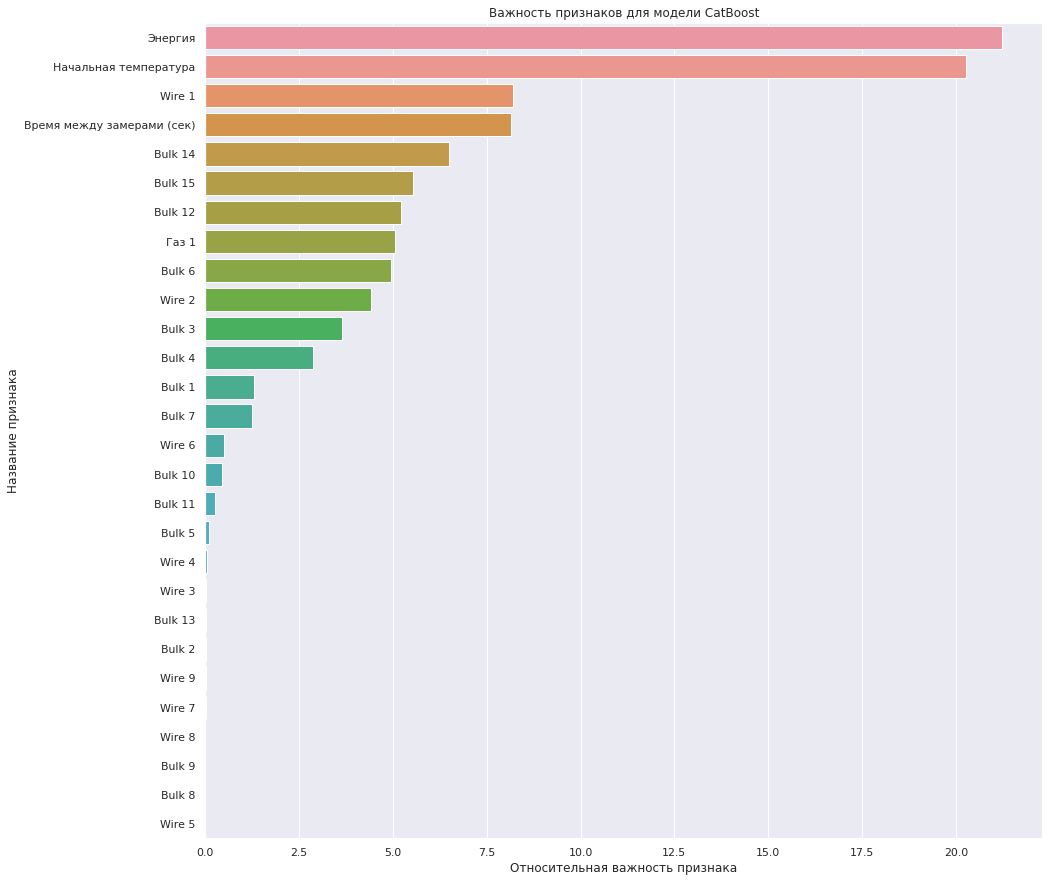

In [ ]:
sns.barplot(data=feature_importance, y='Feature Id', x='Importances')\
.set(title='Важность признаков для модели CatBoost',
     xlabel='Относительная важность признака',
     ylabel='Название признака');

Из полученного графика видно, что на финальную температуру в большей степени влияют начальная температура и переданная сплаву энергия. Также важную роль играет время процедуры (время остывания спалава). Если же рассматривать влияние добавляемых материалов, то в наибольшей степени на предсказания модели влияют добавки материалов `Wire 1` и `Bulk 14`.

## Общий вывод по проекту

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам поставлена задача построить модель, которая предскажет температуру стали.

Доступные нам данные состоят из файлов, полученных из разных источников:
- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Количество строк в файлах различается от 3081 до 14876 штук. Дубликатов данных ни в одном файле обнаружено не было. Во всех файлах были найдены пропуски данных. Каждый файл содержит столбец `key`, возможно его можно будет использовать для объединения таблиц.

Мы провели исследовательский анализ данных, в ходе которого было выявлено несколько проблем:
1. Во всех таблицах были выявлены пропуски данных. Природа части пропусков известна от заказчика.
2. Во всех колонках, содержащих данные о времени совершения операций, отсутствует информация о периоде 11, 12, 13 июля;
3. В некоторых колонках были выявлены подозрительные значения. Они могли появиться в данных например, в результате сбоя измерительного оборудования;
4. Были выявлены замеры температуры менее 1500 градусов;
5. Была выявлена партия с отрицательной реактивной мощностью;
4. Во всех таблицах количество уникальных значений в столбце `key` различается. 

Для подготовки данных к обучению мы удалили значения, которые по согласованию с заказчиком считаются выбросами. Затем мы обработали данные и сформировали дополнительные признаки: рассчитали энергию, переданную сплаву в результате нагрева и время, прошедшее между замерами температуры. Полученные таблицы мы объединили в одну, при этом использовались только те партии (ключи), инфомрация о которых была во всех объединяемых таблицах.

Для получения предсказаний мы выбрали пять моделей:
* линейную регрессию с регуляризацией (ElasticNet)
* метод опорных векторов (SVR)
* случайный лес (RandomForest)
* градиентный бустинг (CatBoost)
* голосующий ансамбль (VotingRegressor).

Для сравнения моделей мы обучили каждую из них на кросс-валидации и получили значения метрики MAE. Результаты представлены в таблице ниже.

*Таблица 1: Значения метрики MAE для различных моделей на кросс-валидации*

| Модель | MAE (к.-в.) |
|---|---|
| ElasticNet | 6.12|
| SVR | 6.51|
| RandomForest | 5.92 |
| CatBoost | 5.87 |
| VotingRegressor | 5.78 |

Наилучший результат показала модель на основе голосующего ансамбля. Её мы отобрали для получения предсказаний на тестовых данных.

На тестовых данных значение метрики оказалось лишь немного выше значения на кросс-валидации.

*Таблица 2: Значение метрики MAE для голосующего регрессора на тестовых данных*

| Модель | MAE (тест) |
|---|---|
| VotingRegressor | 5.84|

Мы также проверили, какие признаки больше всего сказываются на предсказаниях модели. Мы установили, что для определения итоговой температуры сплава важнее всего начальная температура и передаваемая сплаву энергия.